In [31]:
import os
import sys
import math
import time
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

# For classification (ResNet152V2)
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_absolute_error, mean_squared_error

# For downloading pre-trained weights
import gdown

!git clone https://github.com/XGHouE/brain-tumor-analysis/

fatal: destination path 'brain-tumor-analysis' already exists and is not an empty directory.


# Data paths

UNet:

In [32]:
# Sort the image and mask filenames to ensure they match

IMAGES_PATH='/content/brain-tumor-analysis/split_dataset/UNet/scans'
MASKS_PATH='/content/brain-tumor-analysis/split_dataset/UNet/masks'
image_files = sorted(os.listdir(IMAGES_PATH))
mask_files = sorted(os.listdir(MASKS_PATH))
SIZE=256
CHANNEL=1
Num_Of_Classes=1

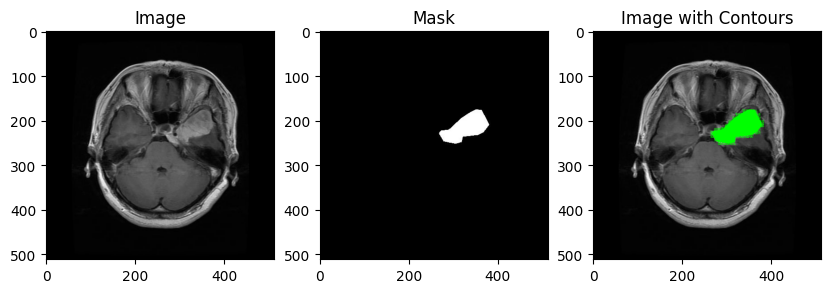

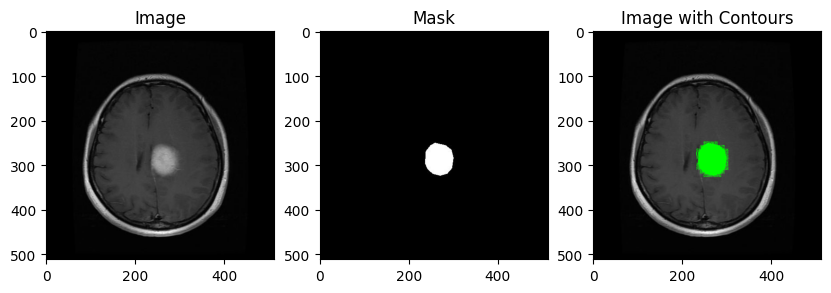

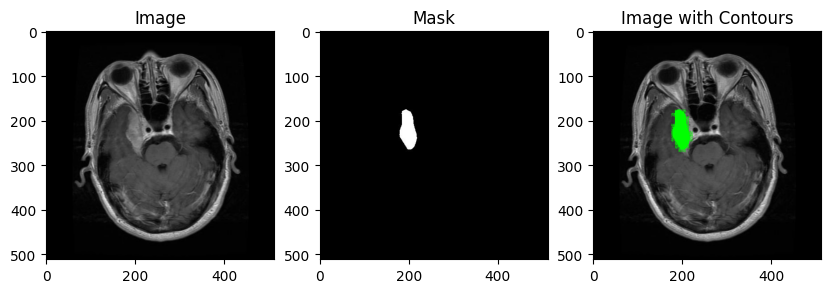

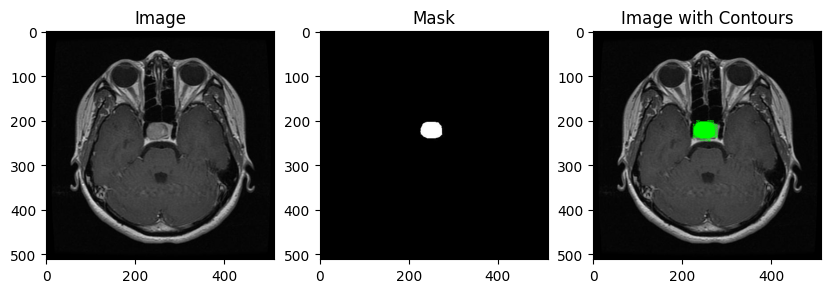

In [33]:
# Ensure data is imported correctly
def display_images_masks(imagepath, maskpath):
  count = 0
  for image_file, mask_file in zip(image_files, mask_files):
    if count >= 4:  # Display only the first 4 images from each folder
        break
    imagepath_full = os.path.join(imagepath, image_file)
    maskpath_full = os.path.join(maskpath, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    if image is None:
        raise ValueError(f"Image at path {imagepath_full} could not be loaded")
    if mask is None:
        raise ValueError(f"Mask at path {maskpath_full} could not be loaded")
    plt.figure(figsize=(10, 10))
    # First subplot (image)
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    # Second subplot (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    # Third subplot (Image with Contours)
    plt.subplot(1, 3, 3)
    sample = np.array(np.squeeze(mask), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
    plt.imshow(sample_over_gt)
    plt.title('Image with Contours')
    plt.show()
    count += 1

display_images_masks(IMAGES_PATH,MASKS_PATH)

In [34]:
images_size=[]
masks_size=[]
for image_file, mask_file in tqdm(zip(image_files, mask_files)):
    imagepath_full = os.path.join(IMAGES_PATH, image_file)
    maskpath_full = os.path.join(MASKS_PATH, mask_file)
    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)
    images_size.append(image.shape)
    masks_size.append(mask.shape)
print(list(set(images_size)))
print("=================")
print(list(set(masks_size)))

4569it [00:07, 644.62it/s]

[(488, 504, 3), (263, 236, 3), (290, 236, 3), (717, 717, 3), (444, 468, 3), (243, 236, 3), (674, 648, 3), (1446, 1375, 3), (210, 233, 3), (302, 216, 3), (530, 380, 3), (512, 434, 3), (251, 447, 3), (250, 201, 3), (274, 230, 3), (252, 236, 3), (442, 442, 3), (249, 201, 3), (320, 296, 3), (228, 233, 3), (218, 233, 3), (480, 853, 3), (725, 728, 3), (248, 208, 3), (484, 405, 3), (600, 600, 3), (483, 430, 3), (417, 428, 3), (506, 444, 3), (630, 630, 3), (223, 236, 3), (614, 630, 3), (344, 320, 3), (228, 235, 3), (273, 236, 3), (236, 236, 3), (243, 200, 3), (504, 450, 3), (244, 206, 3), (470, 469, 3), (273, 251, 3), (214, 229, 3), (496, 453, 3), (264, 235, 3), (248, 203, 3), (474, 356, 3), (1024, 1024, 3), (295, 236, 3), (277, 235, 3), (217, 232, 3), (600, 494, 3), (247, 204, 3), (216, 232, 3), (262, 224, 3), (238, 212, 3), (280, 229, 3), (216, 236, 3), (244, 262, 3), (201, 210, 3), (236, 211, 3), (236, 255, 3), (490, 410, 3), (201, 236, 3), (777, 622, 3), (442, 332, 3), (218, 225, 3), (469,

In [78]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files, mask_files)):
        print(image_file)
        imagepath_full = os.path.join(IMAGES_PATH, image_file)
        maskpath_full = os.path.join(MASKS_PATH, mask_file)
        print(mask_file)
        image = cv2.imread(imagepath_full,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image = image/255.0
        images.append(image)
        mask = cv2.imread(maskpath_full,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE, SIZE), interpolation=cv2.INTER_NEAREST)
        mask = mask/255.0
        masks.append(mask)

    return np.expand_dims(np.array(images), axis=-1), np.expand_dims(np.array(masks), axis=-1)

In [79]:
# Split train and test
X,y=preprocessing_images_masks()
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

75it [00:00, 742.59it/s]

1.jpg
1.jpg
10.jpg
10.jpg
100.jpg
100.jpg
1000.jpg
1000.jpg
1001.jpg
1001.jpg
1002.jpg
1002.jpg
1003.jpg
1003.jpg
1004.jpg
1004.jpg
1005.jpg
1005.jpg
1006.jpg
1006.jpg
1007.jpg
1007.jpg
1008.jpg
1008.jpg
1009.jpg
1009.jpg
101.jpg
101.jpg
1010.jpg
1010.jpg
1011.jpg
1011.jpg
1012.jpg
1012.jpg
1013.jpg
1013.jpg
1014.jpg
1014.jpg
1015.jpg
1015.jpg
1016.jpg
1016.jpg
1017.jpg
1017.jpg
1018.jpg
1018.jpg
1019.jpg
1019.jpg
102.jpg
102.jpg
1020.jpg
1020.jpg
1021.jpg
1021.jpg
1022.jpg
1022.jpg
1023.jpg
1023.jpg
1024.jpg
1024.jpg
1025.jpg
1025.jpg
1026.jpg
1026.jpg
1027.jpg
1027.jpg
1028.jpg
1028.jpg
1029.jpg
1029.jpg
103.jpg
103.jpg
1030.jpg
1030.jpg
1031.jpg
1031.jpg
1032.jpg
1032.jpg
1033.jpg
1033.jpg
1034.jpg
1034.jpg
1035.jpg
1035.jpg
1036.jpg
1036.jpg
1037.jpg
1037.jpg
1038.jpg
1038.jpg
1039.jpg
1039.jpg
104.jpg
104.jpg
1040.jpg
1040.jpg
1041.jpg
1041.jpg
1042.jpg
1042.jpg
1043.jpg
1043.jpg
1044.jpg
1044.jpg
1045.jpg
1045.jpg
1046.jpg
1046.jpg
1047.jpg
1047.jpg
1048.jpg
1048.jpg
1049.jpg
104

230it [00:00, 721.74it/s]

1136.jpg
1136.jpg
1137.jpg
1137.jpg
1138.jpg
1138.jpg
1139.jpg
1139.jpg
114.jpg
114.jpg
1140.jpg
1140.jpg
1141.jpg
1141.jpg
1142.jpg
1142.jpg
1143.jpg
1143.jpg
1144.jpg
1144.jpg
1145.jpg
1145.jpg
1146.jpg
1146.jpg
1147.jpg
1147.jpg
1148.jpg
1148.jpg
1149.jpg
1149.jpg
115.jpg
115.jpg
1150.jpg
1150.jpg
1151.jpg
1151.jpg
1152.jpg
1152.jpg
1153.jpg
1153.jpg
1154.jpg
1154.jpg
1155.jpg
1155.jpg
1156.jpg
1156.jpg
1157.jpg
1157.jpg
1158.jpg
1158.jpg
1159.jpg
1159.jpg
116.jpg
116.jpg
1160.jpg
1160.jpg
1161.jpg
1161.jpg
1162.jpg
1162.jpg
1163.jpg
1163.jpg
1164.jpg
1164.jpg
1165.jpg
1165.jpg
1166.jpg
1166.jpg
1167.jpg
1167.jpg
1168.jpg
1168.jpg
1169.jpg
1169.jpg
117.jpg
117.jpg
1170.jpg
1170.jpg
1171.jpg
1171.jpg
1172.jpg
1172.jpg
1173.jpg
1173.jpg
1174.jpg
1174.jpg
1175.jpg
1175.jpg
1176.jpg
1176.jpg
1177.jpg
1177.jpg
1178.jpg
1178.jpg
1179.jpg
1179.jpg
118.jpg
118.jpg
1180.jpg
1180.jpg
1181.jpg
1181.jpg
1182.jpg
1182.jpg
1183.jpg
1183.jpg
1184.jpg
1184.jpg
1185.jpg
1185.jpg
1186.jpg
1186.jpg
11

368it [00:00, 602.49it/s]

1249.jpg
1249.jpg
125.jpg
125.jpg
1250.jpg
1250.jpg
1251.jpg
1251.jpg
1252.jpg
1252.jpg
1253.jpg
1253.jpg
1254.jpg
1254.jpg
1255.jpg
1255.jpg
1256.jpg
1256.jpg
1257.jpg
1257.jpg
1258.jpg
1258.jpg
1259.jpg
1259.jpg
126.jpg
126.jpg
1260.jpg
1260.jpg
1261.jpg
1261.jpg
1262.jpg
1262.jpg
1263.jpg
1263.jpg
1264.jpg
1264.jpg
1265.jpg
1265.jpg
1266.jpg
1266.jpg
1267.jpg
1267.jpg
1268.jpg
1268.jpg
1269.jpg
1269.jpg
127.jpg
127.jpg
1270.jpg
1270.jpg
1271.jpg
1271.jpg
1272.jpg
1272.jpg
1273.jpg
1273.jpg
1274.jpg
1274.jpg
1275.jpg
1275.jpg
1276.jpg
1276.jpg
1277.jpg
1277.jpg
1278.jpg
1278.jpg
1279.jpg
1279.jpg
128.jpg
128.jpg
1280.jpg
1280.jpg
1281.jpg
1281.jpg
1282.jpg
1282.jpg
1283.jpg
1283.jpg
1284.jpg
1284.jpg
1285.jpg
1285.jpg
1286.jpg
1286.jpg
1287.jpg
1287.jpg
1288.jpg
1288.jpg
1289.jpg
1289.jpg
129.jpg
129.jpg
1290.jpg
1290.jpg
1291.jpg
1291.jpg
1292.jpg
1292.jpg
1293.jpg
1293.jpg
1294.jpg
1294.jpg
1295.jpg
1295.jpg
1296.jpg
1296.jpg
1297.jpg
1297.jpg
1298.jpg
1298.jpg
1299.jpg
1299.jpg
13

489it [00:00, 568.04it/s]

1345.jpg
1345.jpg
1346.jpg
1346.jpg
1347.jpg
1347.jpg
1348.jpg
1348.jpg
1349.jpg
1349.jpg
135.jpg
135.jpg
1350.jpg
1350.jpg
1351.jpg
1351.jpg
1352.jpg
1352.jpg
1353.jpg
1353.jpg
1354.jpg
1354.jpg
1355.jpg
1355.jpg
1356.jpg
1356.jpg
1357.jpg
1357.jpg
1358.jpg
1358.jpg
1359.jpg
1359.jpg
136.jpg
136.jpg
1360.jpg
1360.jpg
1361.jpg
1361.jpg
1362.jpg
1362.jpg
1363.jpg
1363.jpg
1364.jpg
1364.jpg
1365.jpg
1365.jpg
1366.jpg
1366.jpg
1367.jpg
1367.jpg
1368.jpg
1368.jpg
1369.jpg
1369.jpg
137.jpg
137.jpg
1370.jpg
1370.jpg
1371.jpg
1371.jpg
1372.jpg
1372.jpg
1373.jpg
1373.jpg
1374.jpg
1374.jpg
1375.jpg
1375.jpg
1376.jpg
1376.jpg
1377.jpg
1377.jpg
1378.jpg
1378.jpg
1379.jpg
1379.jpg
138.jpg
138.jpg
1380.jpg
1380.jpg
1381.jpg
1381.jpg
1382.jpg
1382.jpg
1383.jpg
1383.jpg
1384.jpg
1384.jpg
1385.jpg
1385.jpg
1386.jpg
1386.jpg
1387.jpg
1387.jpg
1388.jpg
1388.jpg
1389.jpg
1389.jpg
139.jpg
139.jpg
1390.jpg
1390.jpg
1391.jpg
1391.jpg
1392.jpg
1392.jpg
1393.jpg
1393.jpg
1394.jpg
1394.jpg
1395.jpg
1395.jpg
13

547it [00:00, 557.60it/s]

1444.jpg
1444.jpg
1445.jpg
1445.jpg
1446.jpg
1446.jpg
1447.jpg
1447.jpg
1448.jpg
1448.jpg
1449.jpg
1449.jpg
145.jpg
145.jpg
1450.jpg
1450.jpg
1451.jpg
1451.jpg
1452.jpg
1452.jpg
1453.jpg
1453.jpg
1454.jpg
1454.jpg
1455.jpg
1455.jpg
1456.jpg
1456.jpg
1457.jpg
1457.jpg
1458.jpg
1458.jpg
1459.jpg
1459.jpg
146.jpg
146.jpg
1460.jpg
1460.jpg
1461.jpg
1461.jpg
1462.jpg
1462.jpg
1463.jpg
1463.jpg
1464.jpg
1464.jpg
1465.jpg
1465.jpg
1466.jpg
1466.jpg
1467.jpg
1467.jpg
1468.jpg
1468.jpg
1469.jpg
1469.jpg
147.jpg
147.jpg
1470.jpg
1470.jpg
1471.jpg
1471.jpg
1472.jpg
1472.jpg
1473.jpg
1473.jpg
1474.jpg
1474.jpg
1475.jpg
1475.jpg
1476.jpg
1476.jpg
1477.jpg
1477.jpg
1478.jpg
1478.jpg
1479.jpg
1479.jpg
148.jpg
148.jpg
1480.jpg
1480.jpg
1481.jpg
1481.jpg
1482.jpg
1482.jpg
1483.jpg
1483.jpg
1484.jpg
1484.jpg
1485.jpg
1485.jpg
1486.jpg
1486.jpg
1487.jpg
1487.jpg
1488.jpg
1488.jpg
1489.jpg
1489.jpg
149.jpg
149.jpg
1490.jpg
1490.jpg
1491.jpg
1491.jpg
1492.jpg
1492.jpg
1493.jpg
1493.jpg
1494.jpg
1494.jpg
14

658it [00:01, 539.50it/s]

1540.jpg
1540.jpg
1541.jpg
1541.jpg
1542.jpg
1542.jpg
1543.jpg
1543.jpg
1544.jpg
1544.jpg
1545.jpg
1545.jpg
1546.jpg
1546.jpg
1547.jpg
1547.jpg
1548.jpg
1548.jpg
1549.jpg
1549.jpg
155.jpg
155.jpg
1550.jpg
1550.jpg
1551.jpg
1551.jpg
1552.jpg
1552.jpg
1553.jpg
1553.jpg
1554.jpg
1554.jpg
1555.jpg
1555.jpg
1556.jpg
1556.jpg
1557.jpg
1557.jpg
1558.jpg
1558.jpg
1559.jpg
1559.jpg
156.jpg
156.jpg
1560.jpg
1560.jpg
1561.jpg
1561.jpg
1562.jpg
1562.jpg
1563.jpg
1563.jpg
1564.jpg
1564.jpg
1565.jpg
1565.jpg
1566.jpg
1566.jpg
1567.jpg
1567.jpg
1568.jpg
1568.jpg
1569.jpg
1569.jpg
157.jpg
157.jpg
1570.jpg
1570.jpg
1571.jpg
1571.jpg
1572.jpg
1572.jpg
1573.jpg
1573.jpg
1574.jpg
1574.jpg
1575.jpg
1575.jpg
1576.jpg
1576.jpg
1577.jpg
1577.jpg
1578.jpg
1578.jpg
1579.jpg
1579.jpg
158.jpg
158.jpg
1580.jpg
1580.jpg
1581.jpg
1581.jpg
1582.jpg
1582.jpg
1583.jpg
1583.jpg
1584.jpg
1584.jpg
1585.jpg
1585.jpg
1586.jpg
1586.jpg
1587.jpg
1587.jpg
1588.jpg
1588.jpg
1589.jpg
1589.jpg
159.jpg
159.jpg
1590.jpg
1590.jpg
15

766it [00:01, 536.31it/s]

1636.jpg
1636.jpg
1637.jpg
1637.jpg
1638.jpg
1638.jpg
1639.jpg
1639.jpg
164.jpg
164.jpg
1640.jpg
1640.jpg
1641.jpg
1641.jpg
1642.jpg
1642.jpg
1643.jpg
1643.jpg
1644.jpg
1644.jpg
1645.jpg
1645.jpg
1646.jpg
1646.jpg
1647.jpg
1647.jpg
1648.jpg
1648.jpg
1649.jpg
1649.jpg
165.jpg
165.jpg
1650.jpg
1650.jpg
1651.jpg
1651.jpg
1652.jpg
1652.jpg
1653.jpg
1653.jpg
1654.jpg
1654.jpg
1655.jpg
1655.jpg
1656.jpg
1656.jpg
1657.jpg
1657.jpg
1658.jpg
1658.jpg
1659.jpg
1659.jpg
166.jpg
166.jpg
1660.jpg
1660.jpg
1661.jpg
1661.jpg
1662.jpg
1662.jpg
1663.jpg
1663.jpg
1664.jpg
1664.jpg
1665.jpg
1665.jpg
1666.jpg
1666.jpg
1667.jpg
1667.jpg
1668.jpg
1668.jpg
1669.jpg
1669.jpg
167.jpg
167.jpg
1670.jpg
1670.jpg
1671.jpg
1671.jpg
1672.jpg
1672.jpg
1673.jpg
1673.jpg
1674.jpg
1674.jpg
1675.jpg
1675.jpg
1676.jpg
1676.jpg
1677.jpg
1677.jpg
1678.jpg
1678.jpg
1679.jpg
1679.jpg
168.jpg
168.jpg
1680.jpg
1680.jpg
1681.jpg
1681.jpg
1682.jpg
1682.jpg
1683.jpg
1683.jpg
1684.jpg
1684.jpg
1685.jpg
1685.jpg
1686.jpg
1686.jpg
16

874it [00:01, 536.51it/s]

1733.jpg
1733.jpg
1734.jpg
1734.jpg
1735.jpg
1735.jpg
1736.jpg
1736.jpg
1737.jpg
1737.jpg
1738.jpg
1738.jpg
1739.jpg
1739.jpg
174.jpg
174.jpg
1740.jpg
1740.jpg
1741.jpg
1741.jpg
1742.jpg
1742.jpg
1743.jpg
1743.jpg
1744.jpg
1744.jpg
1745.jpg
1745.jpg
1746.jpg
1746.jpg
1747.jpg
1747.jpg
1748.jpg
1748.jpg
1749.jpg
1749.jpg
175.jpg
175.jpg
1750.jpg
1750.jpg
1751.jpg
1751.jpg
1752.jpg
1752.jpg
1753.jpg
1753.jpg
1754.jpg
1754.jpg
1755.jpg
1755.jpg
1756.jpg
1756.jpg
1757.jpg
1757.jpg
1758.jpg
1758.jpg
1759.jpg
1759.jpg
176.jpg
176.jpg
1760.jpg
1760.jpg
1761.jpg
1761.jpg
1762.jpg
1762.jpg
1763.jpg
1763.jpg
1764.jpg
1764.jpg
1765.jpg
1765.jpg
1766.jpg
1766.jpg
1767.jpg
1767.jpg
1768.jpg
1768.jpg
1769.jpg
1769.jpg
177.jpg
177.jpg
1770.jpg
1770.jpg
1771.jpg
1771.jpg
1772.jpg
1772.jpg
1773.jpg
1773.jpg
1774.jpg
1774.jpg
1775.jpg
1775.jpg
1776.jpg
1776.jpg
1777.jpg
1777.jpg
1778.jpg
1778.jpg
1779.jpg
1779.jpg
178.jpg
178.jpg
1780.jpg
1780.jpg
1781.jpg
1781.jpg
1782.jpg
1782.jpg
1783.jpg
1783.jpg
17

986it [00:01, 534.78it/s]

1826.jpg
1826.jpg
1827.jpg
1827.jpg
1828.jpg
1828.jpg
1829.jpg
1829.jpg
183.jpg
183.jpg
1830.jpg
1830.jpg
1831.jpg
1831.jpg
1832.jpg
1832.jpg
1833.jpg
1833.jpg
1834.jpg
1834.jpg
1835.jpg
1835.jpg
1836.jpg
1836.jpg
1837.jpg
1837.jpg
1838.jpg
1838.jpg
1839.jpg
1839.jpg
184.jpg
184.jpg
1840.jpg
1840.jpg
1841.jpg
1841.jpg
1842.jpg
1842.jpg
1843.jpg
1843.jpg
1844.jpg
1844.jpg
1845.jpg
1845.jpg
1846.jpg
1846.jpg
1847.jpg
1847.jpg
1848.jpg
1848.jpg
1849.jpg
1849.jpg
185.jpg
185.jpg
1850.jpg
1850.jpg
1851.jpg
1851.jpg
1852.jpg
1852.jpg
1853.jpg
1853.jpg
1854.jpg
1854.jpg
1855.jpg
1855.jpg
1856.jpg
1856.jpg
1857.jpg
1857.jpg
1858.jpg
1858.jpg
1859.jpg
1859.jpg
186.jpg
186.jpg
1860.jpg
1860.jpg
1861.jpg
1861.jpg
1862.jpg
1862.jpg
1863.jpg
1863.jpg
1864.jpg
1864.jpg
1865.jpg
1865.jpg
1866.jpg
1866.jpg
1867.jpg
1867.jpg
1868.jpg
1868.jpg
1869.jpg
1869.jpg
187.jpg
187.jpg
1870.jpg
1870.jpg
1871.jpg
1871.jpg
1872.jpg
1872.jpg
1873.jpg
1873.jpg
1874.jpg
1874.jpg
1875.jpg
1875.jpg
1876.jpg
1876.jpg
18

1102it [00:01, 556.41it/s]

1929.jpg
1929.jpg
193.jpg
193.jpg
1930.jpg
1930.jpg
1931.jpg
1931.jpg
1932.jpg
1932.jpg
1933.jpg
1933.jpg
1934.jpg
1934.jpg
1935.jpg
1935.jpg
1936.jpg
1936.jpg
1937.jpg
1937.jpg
1938.jpg
1938.jpg
1939.jpg
1939.jpg
194.jpg
194.jpg
1940.jpg
1940.jpg
1941.jpg
1941.jpg
1942.jpg
1942.jpg
1943.jpg
1943.jpg
1944.jpg
1944.jpg
1945.jpg
1945.jpg
1946.jpg
1946.jpg
1947.jpg
1947.jpg
1948.jpg
1948.jpg
1949.jpg
1949.jpg
195.jpg
195.jpg
1950.jpg
1950.jpg
1951.jpg
1951.jpg
1952.jpg
1952.jpg
1953.jpg
1953.jpg
1954.jpg
1954.jpg
1955.jpg
1955.jpg
1956.jpg
1956.jpg
1957.jpg
1957.jpg
1958.jpg
1958.jpg
1959.jpg
1959.jpg
196.jpg
196.jpg
1960.jpg
1960.jpg
1961.jpg
1961.jpg
1962.jpg
1962.jpg
1963.jpg
1963.jpg
1964.jpg
1964.jpg
1965.jpg
1965.jpg
1966.jpg
1966.jpg
1967.jpg
1967.jpg
1968.jpg
1968.jpg
1969.jpg
1969.jpg
197.jpg
197.jpg
1970.jpg
1970.jpg
1971.jpg
1971.jpg
1972.jpg
1972.jpg
1973.jpg
1973.jpg
1974.jpg
1974.jpg
1975.jpg
1975.jpg
1976.jpg
1976.jpg
1977.jpg
1977.jpg
1978.jpg
1978.jpg
1979.jpg
1979.jpg
19

1219it [00:02, 566.95it/s]

2033.jpg
2033.jpg
2034.jpg
2034.jpg
2035.jpg
2035.jpg
2036.jpg
2036.jpg
2037.jpg
2037.jpg
2038.jpg
2038.jpg
2039.jpg
2039.jpg
204.jpg
204.jpg
2040.jpg
2040.jpg
2041.jpg
2041.jpg
2042.jpg
2042.jpg
2043.jpg
2043.jpg
2044.jpg
2044.jpg
2045.jpg
2045.jpg
2046.jpg
2046.jpg
2047.jpg
2047.jpg
2048.jpg
2048.jpg
2049.jpg
2049.jpg
205.jpg
205.jpg
2050.jpg
2050.jpg
2051.jpg
2051.jpg
2052.jpg
2052.jpg
2053.jpg
2053.jpg
2054.jpg
2054.jpg
2055.jpg
2055.jpg
2056.jpg
2056.jpg
2057.jpg
2057.jpg
2058.jpg
2058.jpg
2059.jpg
2059.jpg
206.jpg
206.jpg
2060.jpg
2060.jpg
2061.jpg
2061.jpg
2062.jpg
2062.jpg
2063.jpg
2063.jpg
2064.jpg
2064.jpg
2065.jpg
2065.jpg
2066.jpg
2066.jpg
2067.jpg
2067.jpg
2068.jpg
2068.jpg
2069.jpg
2069.jpg
207.jpg
207.jpg
2070.jpg
2070.jpg
2071.jpg
2071.jpg
2072.jpg
2072.jpg
2073.jpg
2073.jpg
2074.jpg
2074.jpg
2075.jpg
2075.jpg
2076.jpg
2076.jpg
2077.jpg
2077.jpg
2078.jpg
2078.jpg
2079.jpg
2079.jpg
208.jpg
208.jpg
2080.jpg
2080.jpg
2081.jpg
2081.jpg
2082.jpg
2082.jpg
2083.jpg
2083.jpg
20

1336it [00:02, 573.51it/s]

2139.jpg
2139.jpg
214.jpg
214.jpg
2140.jpg
2140.jpg
2141.jpg
2141.jpg
2142.jpg
2142.jpg
2143.jpg
2143.jpg
2144.jpg
2144.jpg
2145.jpg
2145.jpg
2146.jpg
2146.jpg
2147.jpg
2147.jpg
2148.jpg
2148.jpg
2149.jpg
2149.jpg
215.jpg
215.jpg
2150.jpg
2150.jpg
2151.jpg
2151.jpg
2152.jpg
2152.jpg
2153.jpg
2153.jpg
2154.jpg
2154.jpg
2155.jpg
2155.jpg
2156.jpg
2156.jpg
2157.jpg
2157.jpg
2158.jpg
2158.jpg
2159.jpg
2159.jpg
216.jpg
216.jpg
2160.jpg
2160.jpg
2161.jpg
2161.jpg
2162.jpg
2162.jpg
2163.jpg
2163.jpg
2164.jpg
2164.jpg
2165.jpg
2165.jpg
2166.jpg
2166.jpg
2167.jpg
2167.jpg
2168.jpg
2168.jpg
2169.jpg
2169.jpg
217.jpg
217.jpg
2170.jpg
2170.jpg
2171.jpg
2171.jpg
2172.jpg
2172.jpg
2173.jpg
2173.jpg
2174.jpg
2174.jpg
2175.jpg
2175.jpg
2176.jpg
2176.jpg
2177.jpg
2177.jpg
2178.jpg
2178.jpg
2179.jpg
2179.jpg
218.jpg
218.jpg
2180.jpg
2180.jpg
2181.jpg
2181.jpg
2182.jpg
2182.jpg
2183.jpg
2183.jpg
2184.jpg
2184.jpg
2185.jpg
2185.jpg
2186.jpg
2186.jpg
2187.jpg
2187.jpg
2188.jpg
2188.jpg
2189.jpg
2189.jpg
21

1452it [00:02, 571.87it/s]

2244.jpg
2244.jpg
2245.jpg
2245.jpg
2246.jpg
2246.jpg
2247.jpg
2247.jpg
2248.jpg
2248.jpg
2249.jpg
2249.jpg
225.jpg
225.jpg
2250.jpg
2250.jpg
2251.jpg
2251.jpg
2252.jpg
2252.jpg
2253.jpg
2253.jpg
2254.jpg
2254.jpg
2255.jpg
2255.jpg
2256.jpg
2256.jpg
2257.jpg
2257.jpg
2258.jpg
2258.jpg
2259.jpg
2259.jpg
226.jpg
226.jpg
2260.jpg
2260.jpg
2261.jpg
2261.jpg
2262.jpg
2262.jpg
2263.jpg
2263.jpg
2264.jpg
2264.jpg
2265.jpg
2265.jpg
2266.jpg
2266.jpg
2267.jpg
2267.jpg
2268.jpg
2268.jpg
2269.jpg
2269.jpg
227.jpg
227.jpg
2270.jpg
2270.jpg
2271.jpg
2271.jpg
2272.jpg
2272.jpg
2273.jpg
2273.jpg
2274.jpg
2274.jpg
2275.jpg
2275.jpg
2276.jpg
2276.jpg
2277.jpg
2277.jpg
2278.jpg
2278.jpg
2279.jpg
2279.jpg
228.jpg
228.jpg
2280.jpg
2280.jpg
2281.jpg
2281.jpg
2282.jpg
2282.jpg
2283.jpg
2283.jpg
2284.jpg
2284.jpg
2285.jpg
2285.jpg
2286.jpg
2286.jpg
2287.jpg
2287.jpg
2288.jpg
2288.jpg
2289.jpg
2289.jpg
229.jpg
229.jpg
2290.jpg
2290.jpg
2291.jpg
2291.jpg
2292.jpg
2292.jpg
2293.jpg
2293.jpg
2294.jpg
2294.jpg
22

1569it [00:02, 573.44it/s]

2347.jpg
2347.jpg
2348.jpg
2348.jpg
2349.jpg
2349.jpg
235.jpg
235.jpg
2350.jpg
2350.jpg
2351.jpg
2351.jpg
2352.jpg
2352.jpg
2353.jpg
2353.jpg
2354.jpg
2354.jpg
2355.jpg
2355.jpg
2356.jpg
2356.jpg
2357.jpg
2357.jpg
2358.jpg
2358.jpg
2359.jpg
2359.jpg
236.jpg
236.jpg
2360.jpg
2360.jpg
2361.jpg
2361.jpg
2362.jpg
2362.jpg
2363.jpg
2363.jpg
2364.jpg
2364.jpg
2365.jpg
2365.jpg
2366.jpg
2366.jpg
2367.jpg
2367.jpg
2368.jpg
2368.jpg
2369.jpg
2369.jpg
237.jpg
237.jpg
2370.jpg
2370.jpg
2371.jpg
2371.jpg
2372.jpg
2372.jpg
2373.jpg
2373.jpg
2374.jpg
2374.jpg
2375.jpg
2375.jpg
2376.jpg
2376.jpg
2377.jpg
2377.jpg
2378.jpg
2378.jpg
2379.jpg
2379.jpg
238.jpg
238.jpg
2380.jpg
2380.jpg
2381.jpg
2381.jpg
2382.jpg
2382.jpg
2383.jpg
2383.jpg
2384.jpg
2384.jpg
2385.jpg
2385.jpg
2386.jpg
2386.jpg
2387.jpg
2387.jpg
2388.jpg
2388.jpg
2389.jpg
2389.jpg
239.jpg
239.jpg
2390.jpg
2390.jpg
2391.jpg
2391.jpg
2392.jpg
2392.jpg
2393.jpg
2393.jpg
2394.jpg
2394.jpg
2395.jpg
2395.jpg
2396.jpg
2396.jpg
2397.jpg
2397.jpg
23

1684it [00:02, 565.98it/s]

2450.jpg
2450.jpg
2451.jpg
2451.jpg
2452.jpg
2452.jpg
2453.jpg
2453.jpg
2454.jpg
2454.jpg
2455.jpg
2455.jpg
2456.jpg
2456.jpg
2457.jpg
2457.jpg
2458.jpg
2458.jpg
2459.jpg
2459.jpg
246.jpg
246.jpg
2460.jpg
2460.jpg
2461.jpg
2461.jpg
2462.jpg
2462.jpg
2463.jpg
2463.jpg
2464.jpg
2464.jpg
2465.jpg
2465.jpg
2466.jpg
2466.jpg
2467.jpg
2467.jpg
2468.jpg
2468.jpg
2469.jpg
2469.jpg
247.jpg
247.jpg
2470.jpg
2470.jpg
2471.jpg
2471.jpg
2472.jpg
2472.jpg
2473.jpg
2473.jpg
2474.jpg
2474.jpg
2475.jpg
2475.jpg
2476.jpg
2476.jpg
2477.jpg
2477.jpg
2478.jpg
2478.jpg
2479.jpg
2479.jpg
248.jpg
248.jpg
2480.jpg
2480.jpg
2481.jpg
2481.jpg
2482.jpg
2482.jpg
2483.jpg
2483.jpg
2484.jpg
2484.jpg
2485.jpg
2485.jpg
2486.jpg
2486.jpg
2487.jpg
2487.jpg
2488.jpg
2488.jpg
2489.jpg
2489.jpg
249.jpg
249.jpg
2490.jpg
2490.jpg
2491.jpg
2491.jpg
2492.jpg
2492.jpg
2493.jpg
2493.jpg
2494.jpg
2494.jpg
2495.jpg
2495.jpg
2496.jpg
2496.jpg
2497.jpg
2497.jpg
2498.jpg
2498.jpg
2499.jpg
2499.jpg
25.jpg
25.jpg
250.jpg
250.jpg
2500.j

1798it [00:03, 556.95it/s]

2552.jpg
2552.jpg
2553.jpg
2553.jpg
2554.jpg
2554.jpg
2555.jpg
2555.jpg
2556.jpg
2556.jpg
2557.jpg
2557.jpg
2558.jpg
2558.jpg
2559.jpg
2559.jpg
256.jpg
256.jpg
2560.jpg
2560.jpg
2561.jpg
2561.jpg
2562.jpg
2562.jpg
2563.jpg
2563.jpg
2564.jpg
2564.jpg
2565.jpg
2565.jpg
2566.jpg
2566.jpg
2567.jpg
2567.jpg
2568.jpg
2568.jpg
2569.jpg
2569.jpg
257.jpg
257.jpg
2570.jpg
2570.jpg
2571.jpg
2571.jpg
2572.jpg
2572.jpg
2573.jpg
2573.jpg
2574.jpg
2574.jpg
2575.jpg
2575.jpg
2576.jpg
2576.jpg
2577.jpg
2577.jpg
2578.jpg
2578.jpg
2579.jpg
2579.jpg
258.jpg
258.jpg
2580.jpg
2580.jpg
2581.jpg
2581.jpg
2582.jpg
2582.jpg
2583.jpg
2583.jpg
2584.jpg
2584.jpg
2585.jpg
2585.jpg
2586.jpg
2586.jpg
2587.jpg
2587.jpg
2588.jpg
2588.jpg
2589.jpg
2589.jpg
259.jpg
259.jpg
2590.jpg
2590.jpg
2591.jpg
2591.jpg
2592.jpg
2592.jpg
2593.jpg
2593.jpg
2594.jpg
2594.jpg
2595.jpg
2595.jpg
2596.jpg
2596.jpg
2597.jpg
2597.jpg
2598.jpg
2598.jpg
2599.jpg
2599.jpg
26.jpg
26.jpg
260.jpg
260.jpg
2600.jpg
2600.jpg
2601.jpg
2601.jpg
2602.j

1912it [00:03, 561.49it/s]

2652.jpg
2652.jpg
2653.jpg
2653.jpg
2654.jpg
2654.jpg
2655.jpg
2655.jpg
2656.jpg
2656.jpg
2657.jpg
2657.jpg
2658.jpg
2658.jpg
2659.jpg
2659.jpg
266.jpg
266.jpg
2660.jpg
2660.jpg
2661.jpg
2661.jpg
2662.jpg
2662.jpg
2663.jpg
2663.jpg
2664.jpg
2664.jpg
2665.jpg
2665.jpg
2666.jpg
2666.jpg
2667.jpg
2667.jpg
2668.jpg
2668.jpg
2669.jpg
2669.jpg
267.jpg
267.jpg
2670.jpg
2670.jpg
2671.jpg
2671.jpg
2672.jpg
2672.jpg
2673.jpg
2673.jpg
2674.jpg
2674.jpg
2675.jpg
2675.jpg
2676.jpg
2676.jpg
2677.jpg
2677.jpg
2678.jpg
2678.jpg
2679.jpg
2679.jpg
268.jpg
268.jpg
2680.jpg
2680.jpg
2681.jpg
2681.jpg
2682.jpg
2682.jpg
2683.jpg
2683.jpg
2684.jpg
2684.jpg
2685.jpg
2685.jpg
2686.jpg
2686.jpg
2687.jpg
2687.jpg
2688.jpg
2688.jpg
2689.jpg
2689.jpg
269.jpg
269.jpg
2690.jpg
2690.jpg
2691.jpg
2691.jpg
2692.jpg
2692.jpg
2693.jpg
2693.jpg
2694.jpg
2694.jpg
2695.jpg
2695.jpg
2696.jpg
2696.jpg
2697.jpg
2697.jpg
2698.jpg
2698.jpg
2699.jpg
2699.jpg
27.jpg
27.jpg
270.jpg
270.jpg
2700.jpg
2700.jpg
2701.jpg
2701.jpg
2702.j

2025it [00:03, 553.97it/s]

2754.jpg
2754.jpg
2755.jpg
2755.jpg
2756.jpg
2756.jpg
2757.jpg
2757.jpg
2758.jpg
2758.jpg
2759.jpg
2759.jpg
276.jpg
276.jpg
2760.jpg
2760.jpg
2761.jpg
2761.jpg
2762.jpg
2762.jpg
2763.jpg
2763.jpg
2764.jpg
2764.jpg
2765.jpg
2765.jpg
2766.jpg
2766.jpg
2767.jpg
2767.jpg
2768.jpg
2768.jpg
2769.jpg
2769.jpg
277.jpg
277.jpg
2770.jpg
2770.jpg
2771.jpg
2771.jpg
2772.jpg
2772.jpg
2773.jpg
2773.jpg
2774.jpg
2774.jpg
2775.jpg
2775.jpg
2776.jpg
2776.jpg
2777.jpg
2777.jpg
2778.jpg
2778.jpg
2779.jpg
2779.jpg
278.jpg
278.jpg
2780.jpg
2780.jpg
2781.jpg
2781.jpg
2782.jpg
2782.jpg
2783.jpg
2783.jpg
2784.jpg
2784.jpg
2785.jpg
2785.jpg
2786.jpg
2786.jpg
2787.jpg
2787.jpg
2788.jpg
2788.jpg
2789.jpg
2789.jpg
279.jpg
279.jpg
2790.jpg
2790.jpg
2791.jpg
2791.jpg
2792.jpg
2792.jpg
2793.jpg
2793.jpg
2794.jpg
2794.jpg
2795.jpg
2795.jpg
2796.jpg
2796.jpg
2797.jpg
2797.jpg
2798.jpg
2798.jpg
2799.jpg
2799.jpg
28.jpg
28.jpg
280.jpg
280.jpg
2800.jpg
2800.jpg
2801.jpg
2801.jpg
2802.jpg
2802.jpg
2803.jpg
2803.jpg
2804.j

2137it [00:03, 550.38it/s]

2853.jpg
2853.jpg
2854.jpg
2854.jpg
2855.jpg
2855.jpg
2856.jpg
2856.jpg
2857.jpg
2857.jpg
2858.jpg
2858.jpg
2859.jpg
2859.jpg
286.jpg
286.jpg
2860.jpg
2860.jpg
2861.jpg
2861.jpg
2862.jpg
2862.jpg
2863.jpg
2863.jpg
2864.jpg
2864.jpg
2865.jpg
2865.jpg
2866.jpg
2866.jpg
2867.jpg
2867.jpg
2868.jpg
2868.jpg
2869.jpg
2869.jpg
287.jpg
287.jpg
2870.jpg
2870.jpg
2871.jpg
2871.jpg
2872.jpg
2872.jpg
2873.jpg
2873.jpg
2874.jpg
2874.jpg
2875.jpg
2875.jpg
2876.jpg
2876.jpg
2877.jpg
2877.jpg
2878.jpg
2878.jpg
2879.jpg
2879.jpg
288.jpg
288.jpg
2880.jpg
2880.jpg
2881.jpg
2881.jpg
2882.jpg
2882.jpg
2883.jpg
2883.jpg
2884.jpg
2884.jpg
2885.jpg
2885.jpg
2886.jpg
2886.jpg
2887.jpg
2887.jpg
2888.jpg
2888.jpg
2889.jpg
2889.jpg
289.jpg
289.jpg
2890.jpg
2890.jpg
2891.jpg
2891.jpg
2892.jpg
2892.jpg
2893.jpg
2893.jpg
2894.jpg
2894.jpg
2895.jpg
2895.jpg
2896.jpg
2896.jpg
2897.jpg
2897.jpg
2898.jpg
2898.jpg
2899.jpg
2899.jpg
29.jpg
29.jpg
290.jpg
290.jpg
2900.jpg
2900.jpg
2901.jpg
2901.jpg
2902.jpg
2902.jpg
2903.j

2248it [00:03, 548.59it/s]

2953.jpg
2953.jpg
2954.jpg
2954.jpg
2955.jpg
2955.jpg
2956.jpg
2956.jpg
2957.jpg
2957.jpg
2958.jpg
2958.jpg
2959.jpg
2959.jpg
296.jpg
296.jpg
2960.jpg
2960.jpg
2961.jpg
2961.jpg
2962.jpg
2962.jpg
2963.jpg
2963.jpg
2964.jpg
2964.jpg
2965.jpg
2965.jpg
2966.jpg
2966.jpg
2967.jpg
2967.jpg
2968.jpg
2968.jpg
2969.jpg
2969.jpg
297.jpg
297.jpg
2970.jpg
2970.jpg
2971.jpg
2971.jpg
2972.jpg
2972.jpg
2973.jpg
2973.jpg
2974.jpg
2974.jpg
2975.jpg
2975.jpg
2976.jpg
2976.jpg
2977.jpg
2977.jpg
2978.jpg
2978.jpg
2979.jpg
2979.jpg
298.jpg
298.jpg
2980.jpg
2980.jpg
2981.jpg
2981.jpg
2982.jpg
2982.jpg
2983.jpg
2983.jpg
2984.jpg
2984.jpg
2985.jpg
2985.jpg
2986.jpg
2986.jpg
2987.jpg
2987.jpg
2988.jpg
2988.jpg
2989.jpg
2989.jpg
299.jpg
299.jpg
2990.jpg
2990.jpg
2991.jpg
2991.jpg
2992.jpg
2992.jpg
2993.jpg
2993.jpg
2994.jpg
2994.jpg
2995.jpg
2995.jpg
2996.jpg
2996.jpg
2997.jpg
2997.jpg
2998.jpg
2998.jpg
2999.jpg
2999.jpg
3.jpg
3.jpg
30.jpg
30.jpg
300.jpg
300.jpg
3000.jpg
3000.jpg
3001.jpg
3001.jpg
3002.jpg
300

2358it [00:04, 542.99it/s]

3051.jpg
3051.jpg
3052.jpg
3052.jpg
3053.jpg
3053.jpg
3054.jpg
3054.jpg
3055.jpg
3055.jpg
3056.jpg
3056.jpg
3057.jpg
3057.jpg
3058.jpg
3058.jpg
3059.jpg
3059.jpg
306.jpg
306.jpg
3060.jpg
3060.jpg
3061.jpg
3061.jpg
3062.jpg
3062.jpg
3063.jpg
3063.jpg
3064.jpg
3064.jpg
3065.jpg
3065.jpg
3066.jpg
3066.jpg
3067.jpg
3067.jpg
3068.jpg
3068.jpg
3069.jpg
3069.jpg
307.jpg
307.jpg
3070.jpg
3070.jpg
3071.jpg
3071.jpg
3072.jpg
3072.jpg
3073.jpg
3073.jpg
3074.jpg
3074.jpg
3075.jpg
3075.jpg
3076.jpg
3076.jpg
3077.jpg
3077.jpg
3078.jpg
3078.jpg
3079.jpg
3079.jpg
308.jpg
308.jpg
3080.jpg
3080.jpg
3081.jpg
3081.jpg
3082.jpg
3082.jpg
3083.jpg
3083.jpg
3084.jpg
3084.jpg
3085.jpg
3085.jpg
3086.jpg
3086.jpg
3087.jpg
3087.jpg
3088.jpg
3088.jpg
3089.jpg
3089.jpg
309.jpg
309.jpg
3090.jpg
3090.jpg
3091.jpg
3091.jpg
3092.jpg
3092.jpg
3093.jpg
3093.jpg
3094.jpg
3094.jpg
3095.jpg
3095.jpg
3096.jpg
3096.jpg
3097.jpg
3097.jpg
3098.jpg
3098.jpg
3099.jpg
3099.jpg
31.jpg
31.jpg
310.jpg
310.jpg
3100.jpg
3100.jpg
3101.j

2476it [00:04, 561.14it/s]

3154.jpg
3154.jpg
3155.jpg
3155.jpg
3156.jpg
3156.jpg
3157.jpg
3157.jpg
3158.jpg
3158.jpg
3159.jpg
3159.jpg
316.jpg
316.jpg
3160.jpg
3160.jpg
3161.jpg
3161.jpg
3162.jpg
3162.jpg
3163.jpg
3163.jpg
3164.jpg
3164.jpg
3165.jpg
3165.jpg
3166.jpg
3166.jpg
3167.jpg
3167.jpg
3168.jpg
3168.jpg
3169.jpg
3169.jpg
317.jpg
317.jpg
3170.jpg
3170.jpg
3171.jpg
3171.jpg
3172.jpg
3172.jpg
3173.jpg
3173.jpg
3174.jpg
3174.jpg
3175.jpg
3175.jpg
3176.jpg
3176.jpg
3177.jpg
3177.jpg
3178.jpg
3178.jpg
3179.jpg
3179.jpg
318.jpg
318.jpg
3180.jpg
3180.jpg
3181.jpg
3181.jpg
3182.jpg
3182.jpg
3183.jpg
3183.jpg
3184.jpg
3184.jpg
3185.jpg
3185.jpg
3186.jpg
3186.jpg
3187.jpg
3187.jpg
3188.jpg
3188.jpg
3189.jpg
3189.jpg
319.jpg
319.jpg
3190.jpg
3190.jpg
3191.jpg
3191.jpg
3192.jpg
3192.jpg
3193.jpg
3193.jpg
3194.jpg
3194.jpg
3195.jpg
3195.jpg
3196.jpg
3196.jpg
3197.jpg
3197.jpg
3198.jpg
3198.jpg
3199.jpg
3199.jpg
32.jpg
32.jpg
320.jpg
320.jpg
3200.jpg
3200.jpg
3201.jpg
3201.jpg
3202.jpg
3202.jpg
3203.jpg
3203.jpg
3204.j

2588it [00:04, 520.10it/s]

3255.jpg
3255.jpg
3256.jpg
3256.jpg
3257.jpg
3257.jpg
3258.jpg
3258.jpg
3259.jpg
3259.jpg
326.jpg
326.jpg
3260.jpg
3260.jpg
3261.jpg
3261.jpg
3262.jpg
3262.jpg
3263.jpg
3263.jpg
3264.jpg
3264.jpg
3265.jpg
3265.jpg
3266.jpg
3266.jpg
3267.jpg
3267.jpg
3268.jpg
3268.jpg
3269.jpg
3269.jpg
327.jpg
327.jpg
3270.jpg
3270.jpg
3271.jpg
3271.jpg
3272.jpg
3272.jpg
3273.jpg
3273.jpg
3274.jpg
3274.jpg
3275.jpg
3275.jpg
3276.jpg
3276.jpg
3277.jpg
3277.jpg
3278.jpg
3278.jpg
3279.jpg
3279.jpg
328.jpg
328.jpg
3280.jpg
3280.jpg
3281.jpg
3281.jpg
3282.jpg
3282.jpg
3283.jpg
3283.jpg
3284.jpg
3284.jpg
3285.jpg
3285.jpg
3286.jpg
3286.jpg
3287.jpg
3287.jpg
3288.jpg
3288.jpg
3289.jpg
3289.jpg
329.jpg
329.jpg
3290.jpg
3290.jpg
3291.jpg
3291.jpg
3292.jpg
3292.jpg
3293.jpg
3293.jpg
3294.jpg
3294.jpg
3295.jpg
3295.jpg
3296.jpg
3296.jpg
3297.jpg
3297.jpg
3298.jpg
3298.jpg
3299.jpg
3299.jpg
33.jpg
33.jpg
330.jpg
330.jpg
3300.jpg
3300.jpg
3301.jpg
3301.jpg
3302.jpg
3302.jpg
3303.jpg
3303.jpg
3304.jpg
3304.jpg
3305.j

2705it [00:04, 553.31it/s]

3340.jpg
3340.jpg
3341.jpg
3341.jpg
3342.jpg
3342.jpg
3343.jpg
3343.jpg
3344.jpg
3344.jpg
3345.jpg
3345.jpg
3346.jpg
3346.jpg
3347.jpg
3347.jpg
3348.jpg
3348.jpg
3349.jpg
3349.jpg
335.jpg
335.jpg
3350.jpg
3350.jpg
3351.jpg
3351.jpg
3352.jpg
3352.jpg
3353.jpg
3353.jpg
3354.jpg
3354.jpg
3355.jpg
3355.jpg
3356.jpg
3356.jpg
3357.jpg
3357.jpg
3358.jpg
3358.jpg
3359.jpg
3359.jpg
336.jpg
336.jpg
3360.jpg
3360.jpg
3361.jpg
3361.jpg
3362.jpg
3362.jpg
3363.jpg
3363.jpg
3364.jpg
3364.jpg
3365.jpg
3365.jpg
3366.jpg
3366.jpg
3367.jpg
3367.jpg
3368.jpg
3368.jpg
3369.jpg
3369.jpg
337.jpg
337.jpg
3370.jpg
3370.jpg
3371.jpg
3371.jpg
3372.jpg
3372.jpg
3373.jpg
3373.jpg
3374.jpg
3374.jpg
3375.jpg
3375.jpg
3376.jpg
3376.jpg
3377.jpg
3377.jpg
3378.jpg
3378.jpg
3379.jpg
3379.jpg
338.jpg
338.jpg
3380.jpg
3380.jpg
3381.jpg
3381.jpg
3382.jpg
3382.jpg
3383.jpg
3383.jpg
3384.jpg
3384.jpg
3385.jpg
3385.jpg
3386.jpg
3386.jpg
3387.jpg
3387.jpg
3388.jpg
3388.jpg
3389.jpg
3389.jpg
339.jpg
339.jpg
3390.jpg
3390.jpg
33

2833it [00:05, 591.16it/s]

3450.jpg
3450.jpg
3451.jpg
3451.jpg
3452.jpg
3452.jpg
3453.jpg
3453.jpg
3454.jpg
3454.jpg
3455.jpg
3455.jpg
3456.jpg
3456.jpg
3457.jpg
3457.jpg
3458.jpg
3458.jpg
3459.jpg
3459.jpg
346.jpg
346.jpg
3460.jpg
3460.jpg
3461.jpg
3461.jpg
3462.jpg
3462.jpg
3463.jpg
3463.jpg
3464.jpg
3464.jpg
3465.jpg
3465.jpg
3466.jpg
3466.jpg
3467.jpg
3467.jpg
3468.jpg
3468.jpg
3469.jpg
3469.jpg
347.jpg
347.jpg
3470.jpg
3470.jpg
3471.jpg
3471.jpg
3472.jpg
3472.jpg
3473.jpg
3473.jpg
3474.jpg
3474.jpg
3475.jpg
3475.jpg
3476.jpg
3476.jpg
3477.jpg
3477.jpg
3478.jpg
3478.jpg
3479.jpg
3479.jpg
348.jpg
348.jpg
3480.jpg
3480.jpg
3481.jpg
3481.jpg
3482.jpg
3482.jpg
3483.jpg
3483.jpg
3484.jpg
3484.jpg
3485.jpg
3485.jpg
3486.jpg
3486.jpg
3487.jpg
3487.jpg
3488.jpg
3488.jpg
3489.jpg
3489.jpg
349.jpg
349.jpg
3490.jpg
3490.jpg
3491.jpg
3491.jpg
3492.jpg
3492.jpg
3493.jpg
3493.jpg
3494.jpg
3494.jpg
3495.jpg
3495.jpg
3496.jpg
3496.jpg
3497.jpg
3497.jpg
3498.jpg
3498.jpg
3499.jpg
3499.jpg
35.jpg
35.jpg
350.jpg
350.jpg
3500.j

2960it [00:05, 612.59it/s]

3565.jpg
3565.jpg
3566.jpg
3566.jpg
3567.jpg
3567.jpg
3568.jpg
3568.jpg
3569.jpg
3569.jpg
357.jpg
357.jpg
3570.jpg
3570.jpg
3571.jpg
3571.jpg
3572.jpg
3572.jpg
3573.jpg
3573.jpg
3574.jpg
3574.jpg
3575.jpg
3575.jpg
3576.jpg
3576.jpg
3577.jpg
3577.jpg
3578.jpg
3578.jpg
3579.jpg
3579.jpg
358.jpg
358.jpg
3580.jpg
3580.jpg
3581.jpg
3581.jpg
3582.jpg
3582.jpg
3583.jpg
3583.jpg
3584.jpg
3584.jpg
3585.jpg
3585.jpg
3586.jpg
3586.jpg
3587.jpg
3587.jpg
3588.jpg
3588.jpg
3589.jpg
3589.jpg
359.jpg
359.jpg
3590.jpg
3590.jpg
3591.jpg
3591.jpg
3592.jpg
3592.jpg
3593.jpg
3593.jpg
3594.jpg
3594.jpg
3595.jpg
3595.jpg
3596.jpg
3596.jpg
3597.jpg
3597.jpg
3598.jpg
3598.jpg
3599.jpg
3599.jpg
36.jpg
36.jpg
360.jpg
360.jpg
3600.jpg
3600.jpg
3601.jpg
3601.jpg
3602.jpg
3602.jpg
3603.jpg
3603.jpg
3604.jpg
3604.jpg
3605.jpg
3605.jpg
3606.jpg
3606.jpg
3607.jpg
3607.jpg
3608.jpg
3608.jpg
3609.jpg
3609.jpg
361.jpg
361.jpg
3610.jpg
3610.jpg
3611.jpg
3611.jpg
3612.jpg
3612.jpg
3613.jpg
3613.jpg
3614.jpg
3614.jpg
3615.j

3086it [00:05, 619.99it/s]

368.jpg
368.jpg
3680.jpg
3680.jpg
3681.jpg
3681.jpg
3682.jpg
3682.jpg
3683.jpg
3683.jpg
3684.jpg
3684.jpg
3685.jpg
3685.jpg
3686.jpg
3686.jpg
3687.jpg
3687.jpg
3688.jpg
3688.jpg
3689.jpg
3689.jpg
369.jpg
369.jpg
3690.jpg
3690.jpg
3691.jpg
3691.jpg
3692.jpg
3692.jpg
3693.jpg
3693.jpg
3694.jpg
3694.jpg
3695.jpg
3695.jpg
3696.jpg
3696.jpg
3697.jpg
3697.jpg
3698.jpg
3698.jpg
3699.jpg
3699.jpg
37.jpg
37.jpg
370.jpg
370.jpg
3700.jpg
3700.jpg
3701.jpg
3701.jpg
3702.jpg
3702.jpg
3703.jpg
3703.jpg
3704.jpg
3704.jpg
3705.jpg
3705.jpg
3706.jpg
3706.jpg
3707.jpg
3707.jpg
3708.jpg
3708.jpg
3709.jpg
3709.jpg
371.jpg
371.jpg
3710.jpg
3710.jpg
3711.jpg
3711.jpg
3712.jpg
3712.jpg
3713.jpg
3713.jpg
3714.jpg
3714.jpg
3715.jpg
3715.jpg
3716.jpg
3716.jpg
3717.jpg
3717.jpg
3718.jpg
3718.jpg
3719.jpg
3719.jpg
372.jpg
372.jpg
3720.jpg
3720.jpg
3721.jpg
3721.jpg
3722.jpg
3722.jpg
3723.jpg
3723.jpg
3724.jpg
3724.jpg
3725.jpg
3725.jpg
3726.jpg
3726.jpg
3727.jpg
3727.jpg
3728.jpg
3728.jpg
3729.jpg
3729.jpg
373.jp

3211it [00:05, 607.34it/s]

3794.jpg
3794.jpg
3795.jpg
3795.jpg
3796.jpg
3796.jpg
3797.jpg
3797.jpg
3798.jpg
3798.jpg
3799.jpg
3799.jpg
38.jpg
38.jpg
380.jpg
380.jpg
3800.jpg
3800.jpg
3801.jpg
3801.jpg
3802.jpg
3802.jpg
3803.jpg
3803.jpg
3804.jpg
3804.jpg
3805.jpg
3805.jpg
3806.jpg
3806.jpg
3807.jpg
3807.jpg
3808.jpg
3808.jpg
3809.jpg
3809.jpg
381.jpg
381.jpg
3810.jpg
3810.jpg
3811.jpg
3811.jpg
3812.jpg
3812.jpg
3813.jpg
3813.jpg
3814.jpg
3814.jpg
3815.jpg
3815.jpg
3816.jpg
3816.jpg
3817.jpg
3817.jpg
3818.jpg
3818.jpg
3819.jpg
3819.jpg
382.jpg
382.jpg
3820.jpg
3820.jpg
3821.jpg
3821.jpg
3822.jpg
3822.jpg
3823.jpg
3823.jpg
3824.jpg
3824.jpg
3825.jpg
3825.jpg
3826.jpg
3826.jpg
3827.jpg
3827.jpg
3828.jpg
3828.jpg
3829.jpg
3829.jpg
383.jpg
383.jpg
3830.jpg
3830.jpg
3831.jpg
3831.jpg
3832.jpg
3832.jpg
3833.jpg
3833.jpg
3834.jpg
3834.jpg
3835.jpg
3835.jpg
3836.jpg
3836.jpg
3837.jpg
3837.jpg
3838.jpg
3838.jpg
3839.jpg
3839.jpg
384.jpg
384.jpg
3840.jpg
3840.jpg
3841.jpg
3841.jpg
3842.jpg
3842.jpg
3843.jpg
3843.jpg
3844.j

3338it [00:05, 617.72it/s]

3904.jpg
3904.jpg
3905.jpg
3905.jpg
3906.jpg
3906.jpg
3907.jpg
3907.jpg
3908.jpg
3908.jpg
3909.jpg
3909.jpg
3910.jpg
3910.jpg
3911.jpg
3911.jpg
3912.jpg
3912.jpg
3913.jpg
3913.jpg
3914.jpg
3914.jpg
3915.jpg
3915.jpg
3916.jpg
3916.jpg
3917.jpg
3917.jpg
3918.jpg
3918.jpg
3919.jpg
3919.jpg
3920.jpg
3920.jpg
3921.jpg
3921.jpg
3922.jpg
3922.jpg
3923.jpg
3923.jpg
3924.jpg
3924.jpg
3925.jpg
3925.jpg
3926.jpg
3926.jpg
3927.jpg
3927.jpg
3928.jpg
3928.jpg
3929.jpg
3929.jpg
3930.jpg
3930.jpg
3931.jpg
3931.jpg
3932.jpg
3932.jpg
3933.jpg
3933.jpg
3934.jpg
3934.jpg
3935.jpg
3935.jpg
3936.jpg
3936.jpg
3937.jpg
3937.jpg
3938.jpg
3938.jpg
3939.jpg
3939.jpg
3940.jpg
3940.jpg
3941.jpg
3941.jpg
3942.jpg
3942.jpg
3943.jpg
3943.jpg
3944.jpg
3944.jpg
3945.jpg
3945.jpg
3946.jpg
3946.jpg
3947.jpg
3947.jpg
3948.jpg
3948.jpg
3949.jpg
3949.jpg
3950.jpg
3950.jpg
3951.jpg
3951.jpg
3952.jpg
3952.jpg
3953.jpg
3953.jpg
3954.jpg
3954.jpg
3955.jpg
3955.jpg
3956.jpg
3956.jpg
3957.jpg
3957.jpg
3958.jpg
3958.jpg
3959.jpg
3

3400it [00:05, 560.36it/s]

4024.jpg
4024.jpg
4025.jpg
4025.jpg
4026.jpg
4026.jpg
4027.jpg
4027.jpg
4028.jpg
4028.jpg
4029.jpg
4029.jpg
4030.jpg
4030.jpg
4031.jpg
4031.jpg
4032.jpg
4032.jpg
4033.jpg
4033.jpg
4034.jpg
4034.jpg
4035.jpg
4035.jpg
4036.jpg
4036.jpg
4037.jpg
4037.jpg
4038.jpg
4038.jpg
4039.jpg
4039.jpg
4040.jpg
4040.jpg
4041.jpg
4041.jpg
4042.jpg
4042.jpg
4043.jpg
4043.jpg
4044.jpg
4044.jpg
4045.jpg
4045.jpg
4046.jpg
4046.jpg
4047.jpg
4047.jpg
4048.jpg
4048.jpg
4049.jpg
4049.jpg
4050.jpg
4050.jpg
4051.jpg
4051.jpg
4052.jpg
4052.jpg
4053.jpg
4053.jpg
4054.jpg
4054.jpg
4055.jpg
4055.jpg
4056.jpg
4056.jpg
4057.jpg
4057.jpg
4058.jpg
4058.jpg
4059.jpg
4059.jpg
4060.jpg
4060.jpg
4061.jpg
4061.jpg
4062.jpg
4062.jpg
4063.jpg
4063.jpg
4064.jpg
4064.jpg
4065.jpg
4065.jpg
4066.jpg
4066.jpg
4067.jpg
4067.jpg
4068.jpg
4068.jpg
4069.jpg
4069.jpg
4070.jpg
4070.jpg
4071.jpg
4071.jpg
4072.jpg
4072.jpg
4073.jpg
4073.jpg
4074.jpg
4074.jpg
4075.jpg
4075.jpg
4076.jpg
4076.jpg
4077.jpg
4077.jpg
4078.jpg
4078.jpg
4079.jpg
4

3517it [00:06, 553.30it/s]

4120.jpg
4120.jpg
4121.jpg
4121.jpg
4122.jpg
4122.jpg
4123.jpg
4123.jpg
4124.jpg
4124.jpg
4125.jpg
4125.jpg
4126.jpg
4126.jpg
4127.jpg
4127.jpg
4128.jpg
4128.jpg
4129.jpg
4129.jpg
4130.jpg
4130.jpg
4131.jpg
4131.jpg
4132.jpg
4132.jpg
4133.jpg
4133.jpg
4134.jpg
4134.jpg
4135.jpg
4135.jpg
4136.jpg
4136.jpg
4137.jpg
4137.jpg
4138.jpg
4138.jpg
4139.jpg
4139.jpg
4140.jpg
4140.jpg
4141.jpg
4141.jpg
4142.jpg
4142.jpg
4143.jpg
4143.jpg
4144.jpg
4144.jpg
4145.jpg
4145.jpg
4146.jpg
4146.jpg
4147.jpg
4147.jpg
4148.jpg
4148.jpg
4149.jpg
4149.jpg
4150.jpg
4150.jpg
4151.jpg
4151.jpg
4152.jpg
4152.jpg
4153.jpg
4153.jpg
4154.jpg
4154.jpg
4155.jpg
4155.jpg
4156.jpg
4156.jpg
4157.jpg
4157.jpg
4158.jpg
4158.jpg
4159.jpg
4159.jpg
4160.jpg
4160.jpg
4161.jpg
4161.jpg
4162.jpg
4162.jpg
4163.jpg
4163.jpg
4164.jpg
4164.jpg
4165.jpg
4165.jpg
4166.jpg
4166.jpg
4167.jpg
4167.jpg
4168.jpg
4168.jpg
4169.jpg
4169.jpg
4170.jpg
4170.jpg
4171.jpg
4171.jpg
4172.jpg
4172.jpg
4173.jpg
4173.jpg
4174.jpg
4174.jpg
4175.jpg
4

3639it [00:06, 579.62it/s]

4229.jpg
4229.jpg
4230.jpg
4230.jpg
4231.jpg
4231.jpg
4232.jpg
4232.jpg
4233.jpg
4233.jpg
4234.jpg
4234.jpg
4235.jpg
4235.jpg
4236.jpg
4236.jpg
4237.jpg
4237.jpg
4238.jpg
4238.jpg
4239.jpg
4239.jpg
4240.jpg
4240.jpg
4241.jpg
4241.jpg
4242.jpg
4242.jpg
4243.jpg
4243.jpg
4244.jpg
4244.jpg
4245.jpg
4245.jpg
4246.jpg
4246.jpg
4247.jpg
4247.jpg
4248.jpg
4248.jpg
4249.jpg
4249.jpg
4250.jpg
4250.jpg
4251.jpg
4251.jpg
4252.jpg
4252.jpg
4253.jpg
4253.jpg
4254.jpg
4254.jpg
4255.jpg
4255.jpg
4256.jpg
4256.jpg
4257.jpg
4257.jpg
4258.jpg
4258.jpg
4259.jpg
4259.jpg
4260.jpg
4260.jpg
4261.jpg
4261.jpg
4262.jpg
4262.jpg
4263.jpg
4263.jpg
4264.jpg
4264.jpg
4265.jpg
4265.jpg
4266.jpg
4266.jpg
4267.jpg
4267.jpg
4268.jpg
4268.jpg
4269.jpg
4269.jpg
4270.jpg
4270.jpg
4271.jpg
4271.jpg
4272.jpg
4272.jpg
4273.jpg
4273.jpg
4274.jpg
4274.jpg
4275.jpg
4275.jpg
4276.jpg
4276.jpg
4277.jpg
4277.jpg
4278.jpg
4278.jpg
4279.jpg
4279.jpg
4280.jpg
4280.jpg
4281.jpg
4281.jpg
4282.jpg
4282.jpg
4283.jpg
4283.jpg
4284.jpg
4

3768it [00:06, 609.35it/s]

4358.jpg
4358.jpg
4359.jpg
4359.jpg
4360.jpg
4360.jpg
4361.jpg
4361.jpg
4362.jpg
4362.jpg
4363.jpg
4363.jpg
4364.jpg
4364.jpg
4365.jpg
4365.jpg
4366.jpg
4366.jpg
4367.jpg
4367.jpg
4368.jpg
4368.jpg
4369.jpg
4369.jpg
4370.jpg
4370.jpg
4371.jpg
4371.jpg
4372.jpg
4372.jpg
4373.jpg
4373.jpg
4374.jpg
4374.jpg
4375.jpg
4375.jpg
4376.jpg
4376.jpg
4377.jpg
4377.jpg
4378.jpg
4378.jpg
4379.jpg
4379.jpg
4380.jpg
4380.jpg
4381.jpg
4381.jpg
4382.jpg
4382.jpg
4383.jpg
4383.jpg
4384.jpg
4384.jpg
4385.jpg
4385.jpg
4386.jpg
4386.jpg
4387.jpg
4387.jpg
4388.jpg
4388.jpg
4389.jpg
4389.jpg
4390.jpg
4390.jpg
4391.jpg
4391.jpg
4392.jpg
4392.jpg
4393.jpg
4393.jpg
4394.jpg
4394.jpg
4395.jpg
4395.jpg
4396.jpg
4396.jpg
4397.jpg
4397.jpg
4398.jpg
4398.jpg
4399.jpg
4399.jpg
44.jpg
44.jpg
4400.jpg
4400.jpg
4401.jpg
4401.jpg
4402.jpg
4402.jpg
4403.jpg
4403.jpg
4404.jpg
4404.jpg
4405.jpg
4405.jpg
4406.jpg
4406.jpg
4407.jpg
4407.jpg
4408.jpg
4408.jpg
4409.jpg
4409.jpg
4410.jpg
4410.jpg
4411.jpg
4411.jpg
4412.jpg
4412.

3898it [00:06, 626.74it/s]

4489.jpg
4489.jpg
4490.jpg
4490.jpg
4491.jpg
4491.jpg
4492.jpg
4492.jpg
4493.jpg
4493.jpg
4494.jpg
4494.jpg
4495.jpg
4495.jpg
4496.jpg
4496.jpg
4497.jpg
4497.jpg
4498.jpg
4498.jpg
4499.jpg
4499.jpg
45.jpg
45.jpg
4500.jpg
4500.jpg
4501.jpg
4501.jpg
4502.jpg
4502.jpg
4503.jpg
4503.jpg
4504.jpg
4504.jpg
4505.jpg
4505.jpg
4506.jpg
4506.jpg
4507.jpg
4507.jpg
4508.jpg
4508.jpg
4509.jpg
4509.jpg
4510.jpg
4510.jpg
4511.jpg
4511.jpg
4512.jpg
4512.jpg
4513.jpg
4513.jpg
4514.jpg
4514.jpg
4515.jpg
4515.jpg
4516.jpg
4516.jpg
4517.jpg
4517.jpg
4518.jpg
4518.jpg
4519.jpg
4519.jpg
4520.jpg
4520.jpg
4521.jpg
4521.jpg
4522.jpg
4522.jpg
4523.jpg
4523.jpg
4524.jpg
4524.jpg
4525.jpg
4525.jpg
4526.jpg
4526.jpg
4527.jpg
4527.jpg
4528.jpg
4528.jpg
4529.jpg
4529.jpg
4530.jpg
4530.jpg
4531.jpg
4531.jpg
4532.jpg
4532.jpg
4533.jpg
4533.jpg
4534.jpg
4534.jpg
4535.jpg
4535.jpg
4536.jpg
4536.jpg
4537.jpg
4537.jpg
4538.jpg
4538.jpg
4539.jpg
4539.jpg
4540.jpg
4540.jpg
4541.jpg
4541.jpg
4542.jpg
4542.jpg
4543.jpg
4543.

4027it [00:07, 620.28it/s]

4613.jpg
4613.jpg
4614.jpg
4614.jpg
4615.jpg
4615.jpg
4616.jpg
4616.jpg
4617.jpg
4617.jpg
4618.jpg
4618.jpg
4619.jpg
4619.jpg
4620.jpg
4620.jpg
4621.jpg
4621.jpg
4622.jpg
4622.jpg
4623.jpg
4623.jpg
4624.jpg
4624.jpg
4625.jpg
4625.jpg
4626.jpg
4626.jpg
4627.jpg
4627.jpg
4628.jpg
4628.jpg
4629.jpg
4629.jpg
4630.jpg
4630.jpg
4631.jpg
4631.jpg
4632.jpg
4632.jpg
4633.jpg
4633.jpg
4634.jpg
4634.jpg
4635.jpg
4635.jpg
4636.jpg
4636.jpg
4637.jpg
4637.jpg
4638.jpg
4638.jpg
4639.jpg
4639.jpg
4640.jpg
4640.jpg
4641.jpg
4641.jpg
4642.jpg
4642.jpg
4643.jpg
4643.jpg
4644.jpg
4644.jpg
4645.jpg
4645.jpg
4646.jpg
4646.jpg
4647.jpg
4647.jpg
4648.jpg
4648.jpg
4649.jpg
4649.jpg
4650.jpg
4650.jpg
4651.jpg
4651.jpg
4652.jpg
4652.jpg
4653.jpg
4653.jpg
4654.jpg
4654.jpg
4655.jpg
4655.jpg
4656.jpg
4656.jpg
4657.jpg
4657.jpg
4658.jpg
4658.jpg
4659.jpg
4659.jpg
47.jpg
47.jpg
478.jpg
478.jpg
479.jpg
479.jpg
48.jpg
48.jpg
480.jpg
480.jpg
481.jpg
481.jpg
482.jpg
482.jpg
483.jpg
483.jpg
484.jpg
484.jpg
485.jpg
485.jp

4150it [00:07, 581.69it/s]

541.jpg
541.jpg
542.jpg
542.jpg
543.jpg
543.jpg
544.jpg
544.jpg
545.jpg
545.jpg
546.jpg
546.jpg
547.jpg
547.jpg
548.jpg
548.jpg
549.jpg
549.jpg
55.jpg
55.jpg
550.jpg
550.jpg
551.jpg
551.jpg
552.jpg
552.jpg
553.jpg
553.jpg
554.jpg
554.jpg
555.jpg
555.jpg
556.jpg
556.jpg
557.jpg
557.jpg
558.jpg
558.jpg
559.jpg
559.jpg
56.jpg
56.jpg
560.jpg
560.jpg
561.jpg
561.jpg
562.jpg
562.jpg
563.jpg
563.jpg
564.jpg
564.jpg
565.jpg
565.jpg
566.jpg
566.jpg
567.jpg
567.jpg
568.jpg
568.jpg
569.jpg
569.jpg
57.jpg
57.jpg
570.jpg
570.jpg
571.jpg
571.jpg
572.jpg
572.jpg
573.jpg
573.jpg
574.jpg
574.jpg
575.jpg
575.jpg
576.jpg
576.jpg
577.jpg
577.jpg
578.jpg
578.jpg
579.jpg
579.jpg
58.jpg
58.jpg
580.jpg
580.jpg
581.jpg
581.jpg
582.jpg
582.jpg
583.jpg
583.jpg
584.jpg
584.jpg
585.jpg
585.jpg
586.jpg
586.jpg
587.jpg
587.jpg
588.jpg
588.jpg
589.jpg
589.jpg
59.jpg
59.jpg
590.jpg
590.jpg
591.jpg
591.jpg
592.jpg
592.jpg
593.jpg
593.jpg
594.jpg
594.jpg
595.jpg
595.jpg
596.jpg
596.jpg
597.jpg
597.jpg
598.jpg
598.jpg
59

4267it [00:07, 565.81it/s]

641.jpg
641.jpg
642.jpg
642.jpg
643.jpg
643.jpg
644.jpg
644.jpg
645.jpg
645.jpg
646.jpg
646.jpg
647.jpg
647.jpg
648.jpg
648.jpg
649.jpg
649.jpg
65.jpg
65.jpg
650.jpg
650.jpg
651.jpg
651.jpg
652.jpg
652.jpg
653.jpg
653.jpg
654.jpg
654.jpg
655.jpg
655.jpg
656.jpg
656.jpg
657.jpg
657.jpg
658.jpg
658.jpg
659.jpg
659.jpg
66.jpg
66.jpg
660.jpg
660.jpg
661.jpg
661.jpg
662.jpg
662.jpg
663.jpg
663.jpg
664.jpg
664.jpg
665.jpg
665.jpg
666.jpg
666.jpg
667.jpg
667.jpg
668.jpg
668.jpg
669.jpg
669.jpg
67.jpg
67.jpg
670.jpg
670.jpg
671.jpg
671.jpg
672.jpg
672.jpg
673.jpg
673.jpg
674.jpg
674.jpg
675.jpg
675.jpg
676.jpg
676.jpg
677.jpg
677.jpg
678.jpg
678.jpg
679.jpg
679.jpg
68.jpg
68.jpg
680.jpg
680.jpg
681.jpg
681.jpg
682.jpg
682.jpg
683.jpg
683.jpg
684.jpg
684.jpg
685.jpg
685.jpg
686.jpg
686.jpg
687.jpg
687.jpg
688.jpg
688.jpg
689.jpg
689.jpg
69.jpg
69.jpg
690.jpg
690.jpg
691.jpg
691.jpg
692.jpg
692.jpg
693.jpg
693.jpg
694.jpg
694.jpg
695.jpg
695.jpg
696.jpg
696.jpg
697.jpg
697.jpg
698.jpg
698.jpg
69

4381it [00:07, 563.15it/s]

742.jpg
742.jpg
743.jpg
743.jpg
744.jpg
744.jpg
745.jpg
745.jpg
746.jpg
746.jpg
747.jpg
747.jpg
748.jpg
748.jpg
749.jpg
749.jpg
75.jpg
75.jpg
750.jpg
750.jpg
751.jpg
751.jpg
752.jpg
752.jpg
753.jpg
753.jpg
754.jpg
754.jpg
755.jpg
755.jpg
756.jpg
756.jpg
757.jpg
757.jpg
758.jpg
758.jpg
759.jpg
759.jpg
76.jpg
76.jpg
760.jpg
760.jpg
761.jpg
761.jpg
762.jpg
762.jpg
763.jpg
763.jpg
764.jpg
764.jpg
765.jpg
765.jpg
766.jpg
766.jpg
767.jpg
767.jpg
768.jpg
768.jpg
769.jpg
769.jpg
77.jpg
77.jpg
770.jpg
770.jpg
771.jpg
771.jpg
772.jpg
772.jpg
773.jpg
773.jpg
774.jpg
774.jpg
775.jpg
775.jpg
776.jpg
776.jpg
777.jpg
777.jpg
778.jpg
778.jpg
779.jpg
779.jpg
78.jpg
78.jpg
780.jpg
780.jpg
781.jpg
781.jpg
782.jpg
782.jpg
783.jpg
783.jpg
784.jpg
784.jpg
785.jpg
785.jpg
786.jpg
786.jpg
787.jpg
787.jpg
788.jpg
788.jpg
789.jpg
789.jpg
79.jpg
79.jpg
790.jpg
790.jpg
791.jpg
791.jpg
792.jpg
792.jpg
793.jpg
793.jpg
794.jpg
794.jpg
795.jpg
795.jpg
796.jpg
796.jpg
797.jpg
797.jpg
798.jpg
798.jpg
799.jpg
799.jpg
8.

4494it [00:07, 553.71it/s]

844.jpg
844.jpg
845.jpg
845.jpg
846.jpg
846.jpg
847.jpg
847.jpg
848.jpg
848.jpg
849.jpg
849.jpg
85.jpg
85.jpg
850.jpg
850.jpg
851.jpg
851.jpg
852.jpg
852.jpg
853.jpg
853.jpg
854.jpg
854.jpg
855.jpg
855.jpg
856.jpg
856.jpg
857.jpg
857.jpg
858.jpg
858.jpg
859.jpg
859.jpg
86.jpg
86.jpg
860.jpg
860.jpg
861.jpg
861.jpg
862.jpg
862.jpg
863.jpg
863.jpg
864.jpg
864.jpg
865.jpg
865.jpg
866.jpg
866.jpg
867.jpg
867.jpg
868.jpg
868.jpg
869.jpg
869.jpg
87.jpg
87.jpg
870.jpg
870.jpg
871.jpg
871.jpg
872.jpg
872.jpg
873.jpg
873.jpg
874.jpg
874.jpg
875.jpg
875.jpg
876.jpg
876.jpg
877.jpg
877.jpg
878.jpg
878.jpg
879.jpg
879.jpg
88.jpg
88.jpg
880.jpg
880.jpg
881.jpg
881.jpg
882.jpg
882.jpg
883.jpg
883.jpg
884.jpg
884.jpg
885.jpg
885.jpg
886.jpg
886.jpg
887.jpg
887.jpg
888.jpg
888.jpg
889.jpg
889.jpg
89.jpg
89.jpg
890.jpg
890.jpg
891.jpg
891.jpg
892.jpg
892.jpg
893.jpg
893.jpg
894.jpg
894.jpg
895.jpg
895.jpg
896.jpg
896.jpg
897.jpg
897.jpg
898.jpg
898.jpg
899.jpg
899.jpg
9.jpg
9.jpg
90.jpg
90.jpg
900.jpg


4569it [00:07, 571.94it/s]


942.jpg
942.jpg
943.jpg
943.jpg
944.jpg
944.jpg
945.jpg
945.jpg
946.jpg
946.jpg
947.jpg
947.jpg
948.jpg
948.jpg
949.jpg
949.jpg
95.jpg
95.jpg
950.jpg
950.jpg
951.jpg
951.jpg
952.jpg
952.jpg
953.jpg
953.jpg
954.jpg
954.jpg
955.jpg
955.jpg
956.jpg
956.jpg
957.jpg
957.jpg
958.jpg
958.jpg
959.jpg
959.jpg
96.jpg
96.jpg
960.jpg
960.jpg
961.jpg
961.jpg
962.jpg
962.jpg
963.jpg
963.jpg
964.jpg
964.jpg
965.jpg
965.jpg
966.jpg
966.jpg
967.jpg
967.jpg
968.jpg
968.jpg
969.jpg
969.jpg
97.jpg
97.jpg
970.jpg
970.jpg
971.jpg
971.jpg
972.jpg
972.jpg
973.jpg
973.jpg
974.jpg
974.jpg
975.jpg
975.jpg
976.jpg
976.jpg
977.jpg
977.jpg
978.jpg
978.jpg
979.jpg
979.jpg
98.jpg
98.jpg
980.jpg
980.jpg
981.jpg
981.jpg
982.jpg
982.jpg
983.jpg
983.jpg
984.jpg
984.jpg
985.jpg
985.jpg
986.jpg
986.jpg
987.jpg
987.jpg
988.jpg
988.jpg
989.jpg
989.jpg
99.jpg
99.jpg
990.jpg
990.jpg
991.jpg
991.jpg
992.jpg
992.jpg
993.jpg
993.jpg
994.jpg
994.jpg
995.jpg
995.jpg
996.jpg
996.jpg
997.jpg
997.jpg
998.jpg
998.jpg
999.jpg
999.jpg
Th

In [37]:
# Helpful metrics to define...
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

ResNet

In [24]:
train_dir = pathlib.Path("/content/brain-tumor-analysis/split_dataset/ResNet/Training Set")
test_dir = pathlib.Path("/content/brain-tumor-analysis/split_dataset/ResNet/Testing Set")

img_height = 256
img_width = 256
batch_size = 32
epochs = 30

In [81]:
# Data Preprocesssing
# Loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
    interpolation="bilinear",
    label_mode="int",
)

# Get class names
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

# Normalize and apply data augmentation
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=batch_size,
    shuffle=False,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3654 files belonging to 4 classes.
Using 2924 files for training.
Classes in the dataset: ['Glioma', 'Meningioma', 'NoTumor', 'Pituitary']
Found 3654 files belonging to 4 classes.
Using 730 files for validation.
Found 915 files belonging to 4 classes.


In [26]:
# Different classes have different weights...
def get_class_weights(train_ds, class_names):
    print("Calculating class weights...")

    labels = []
    for image_batch, label_batch in train_ds:
        labels.append(label_batch.numpy())

    labels = np.concatenate(labels)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

    class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}
    print("Class weights calculated.")
    return class_weight_dict

class_weight_dict = get_class_weights(train_ds, class_names)

Calculating class weights...
Class weights calculated.


# Define models

UNet

In [50]:
def unet_model(input_size=(SIZE, SIZE, CHANNEL), num_classes=Num_Of_Classes):
    inputs = keras.layers.Input(input_size)

    # Encoding (Downsampling)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding (Upsampling)
    u6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Create and compile the model
model = unet_model(input_size=(SIZE, SIZE,CHANNEL), num_classes=Num_Of_Classes)

model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy',dice_coef])
# Summary of the model
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_133 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_134 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_133[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 128, 128, 64)   │              0 │ conv2d_134[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_135 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_136 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_135[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_38          │ (None, 64, 64, 128)    │              0 │ conv2d_136[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_137 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_38[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_138 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_137[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_39          │ (None, 32, 32, 256)    │              0 │ conv2d_138[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_139 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_39[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_139[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 16, 16, 512)    │              0 │ conv2d_140[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_141 (Conv2D)       │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_141[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_28       │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_142[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_28       

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

ResNet

In [51]:
# Define the model
base_model3 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [63]:
def create_and_train_model(base_model, model_name, train_ds, val_ds, test_ds, num_classes=4, learning_rate=1e-5, epochs=epochs, class_weight=None):
    for layer in base_model.layers[:10]:
      layer.trainable = False

    base_model_output = base_model.output
    x = layers.GlobalAveragePooling2D()(base_model_output)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    print(f"\nSummary of {model_name}:")
    model.summary()

    model_checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        train_ds,
        shuffle=True,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=[model_checkpoint, reduce_lr]
    )

    # End time tracking
    end_time = time.time()

    # Calculate computation time
    computation_time = end_time - start_time

    print(f"Model training took {computation_time:.2f} seconds.")

    print(f"\nEvaluating {model_name}...")
    print(f"\nClass Weights used in training {model_name}: {class_weight}")
    loss, accuracy = model.evaluate(test_ds)
    print('Loss:', loss)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    model.save(f'{model_name}.keras')
    evaluation = model.evaluate(test_ds)

    return model, history, evaluation, computation_time

# Training

UNet

In [53]:
earlystopping=tf.keras.callbacks.EarlyStopping(patience=20,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=15,
                                                 min_lr=1e-6,
                                                 mode='min')
history = model.fit(X_train, y_train, batch_size=32, epochs=30,
                    validation_data=(X_test, y_test),
                    verbose=1, callbacks=[earlystopping, reduce_lr])
model.save(f'unet_original.keras')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


229/229 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.7674 - dice_coef: 0.0431 - loss: 0.9569 - val_accuracy: 0.9859 - val_dice_coef: 0.2579 - val_loss: 0.7452 - learning_rate: 1.0000e-05
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9584 - dice_coef: 0.1981 - loss: 0.8019 - val_accuracy: 0.9861 - val_dice_coef: 0.3304 - val_loss: 0.6743 - learning_rate: 1.0000e-05
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9839 - dice_coef: 0.3035 - loss: 0.6965 - val_accuracy: 0.9875 - val_dice_coef: 0.4066 - val_loss: 0.5990 - learning_rate: 1.0000e-05
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9862 - dice_coef: 0.3829 - loss: 0.6171 - val_accuracy: 0.9887 - val_dice_coef: 0.4591 - val_loss: 0.5465 - learning_rate: 1.0000e-05
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9868 - dice_coef: 0.4118 - loss: 0.5882 - val_accuracy: 0.9857 - val_dice_coef: 0.4468 - val_loss: 0.5538 - learning_rate: 1.0000e-05


ResNet

In [54]:
print(train_ds)
model3, history3, evaluation3, time3 = create_and_train_model(base_model3, 'model3_resnet152v2_class_weights', train_ds, val_ds, test_ds, epochs=epochs, class_weight=class_weight_dict)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Summary of model3_resnet152v2_class_weights:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 64, 64, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 64, 64, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 66, 66, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 59,382,788 (226.53 MB)

 Trainable params: 59,225,220 (225.93 MB)

 Non-trainable params: 157,568 (615.50 KB)

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 258s 667ms/step - accuracy: 0.5791 - loss: 5.0136 - val_accuracy: 0.3534 - val_loss: 643.3976 - learning_rate: 0.0010
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 66s 360ms/step - accuracy: 0.7357 - loss: 0.9395 - val_accuracy: 0.7671 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.7573 - loss: 0.7619 - val_accuracy: 0.5370 - val_loss: 2.3747 - learning_rate: 0.0010
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.7577 - loss: 0.7249 - val_accuracy: 0.4164 - val_loss: 2.2635 - learning_rate: 0.0010
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 336ms/step - accuracy: 0.8112 - loss: 0.5961 - val_accuracy: 0.3890 - val_loss: 3.2183 - learning_rate: 0.0010
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.8152 - loss: 0.5688 - val_accuracy: 0.3986 - val_loss: 10.3343 - learning_rate: 0.0010
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 66s 359ms/step - accuracy:

# Evaluation

UNet

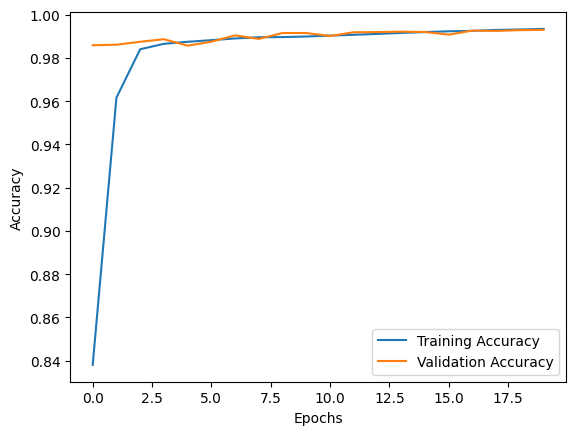

In [55]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

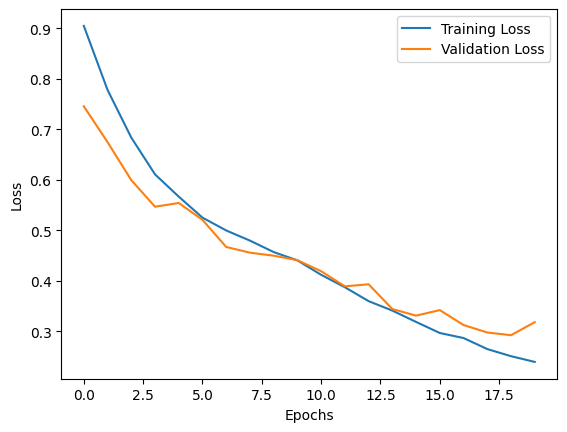

In [56]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
u_net_loss,u_net_accuracy,u_net_dice_coef=model.evaluate(X_test,y_test)
print(f'Loss is {u_net_loss}')
print(f'Accuracy is {u_net_accuracy}')
print(f'Dice_Coef is {u_net_dice_coef}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9937 - dice_coef: 0.7014 - loss: 0.2986
Loss is 0.31759315729141235
Accuracy is 0.9929875135421753
Dice_Coef is 0.6830326318740845


In [58]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1928']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


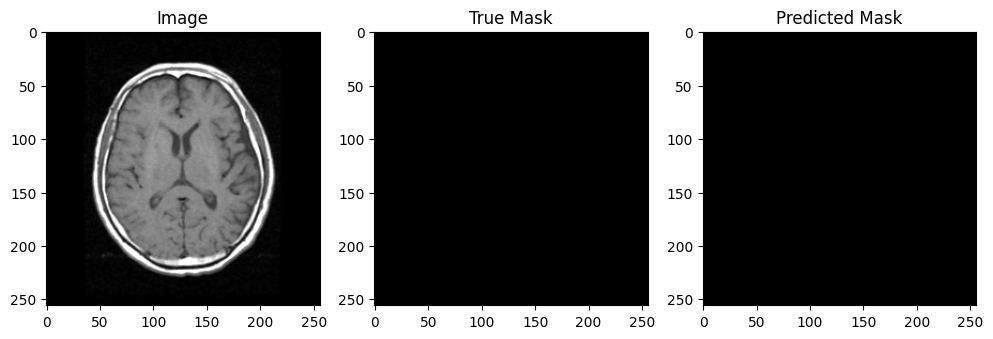

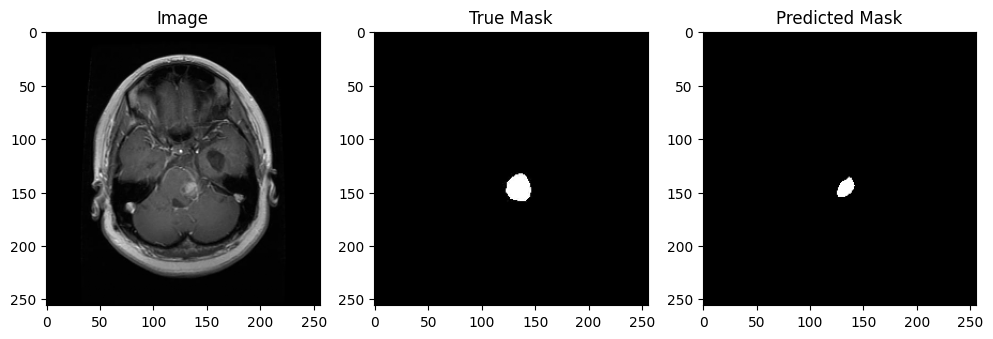

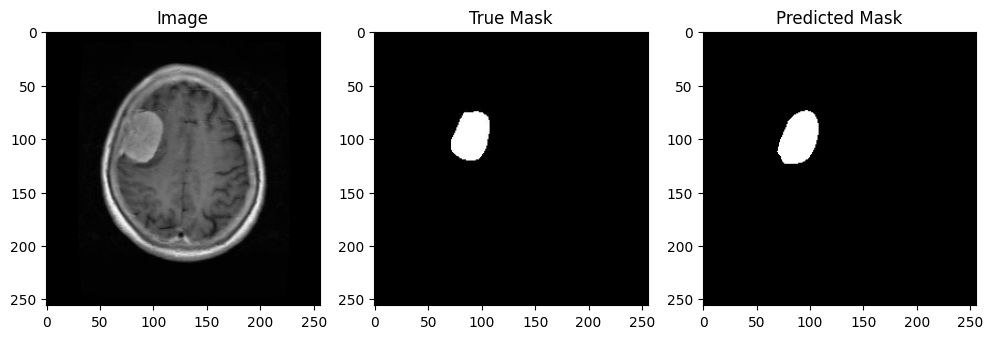

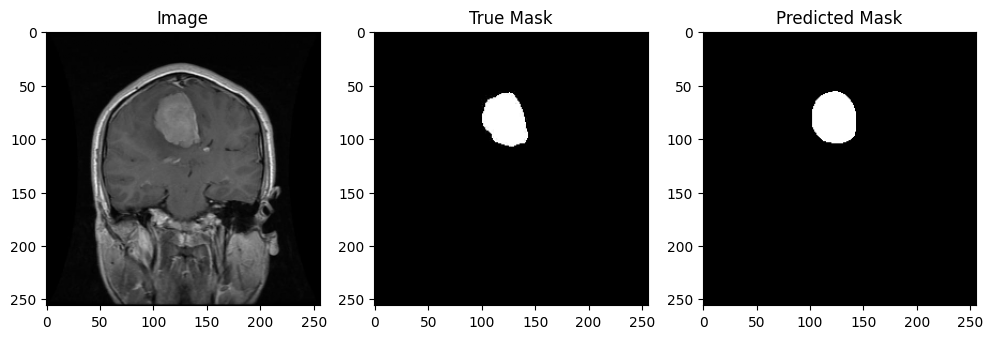

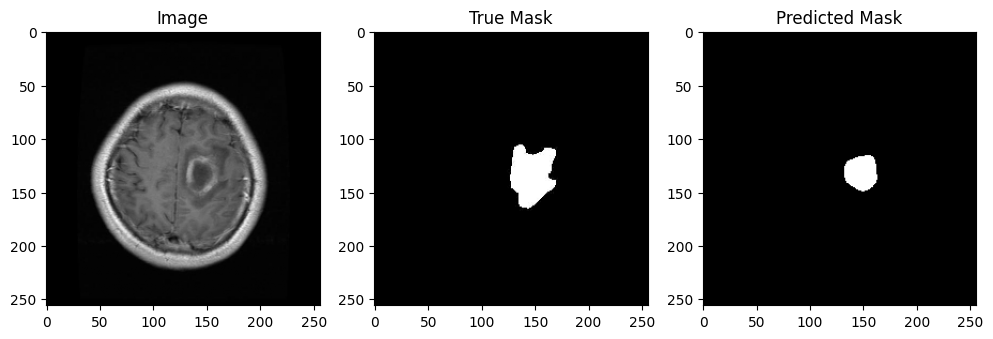

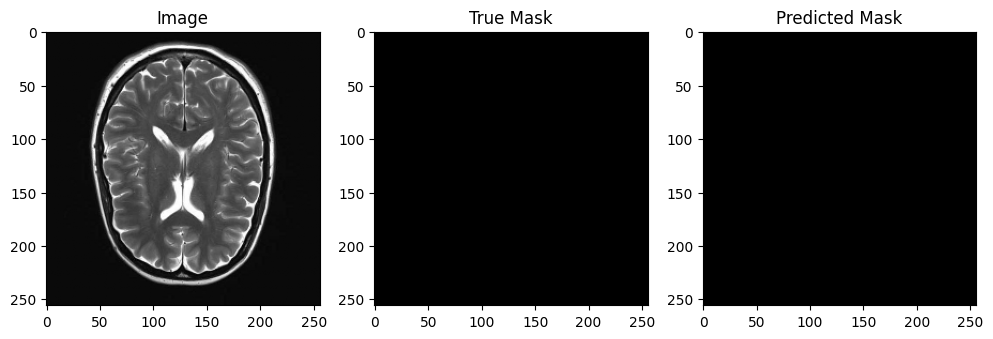

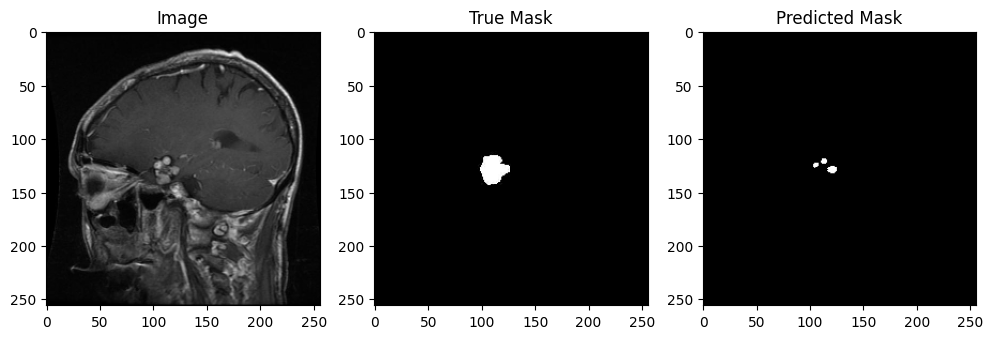

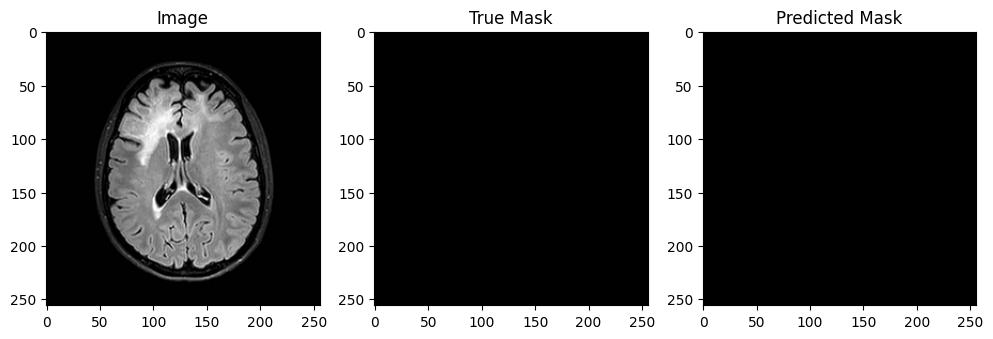

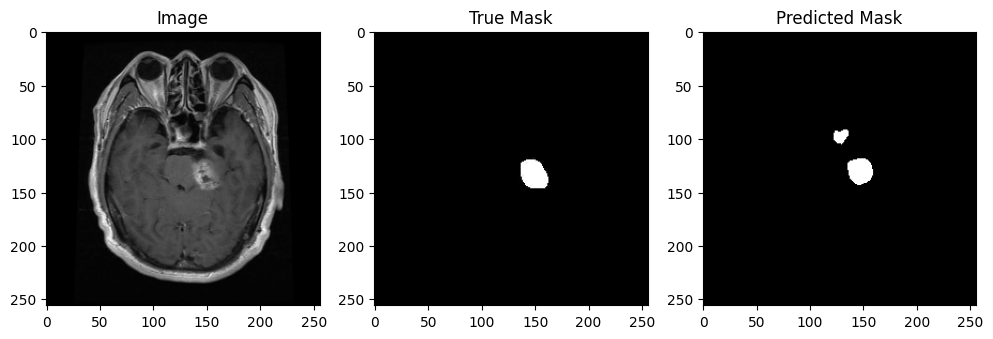

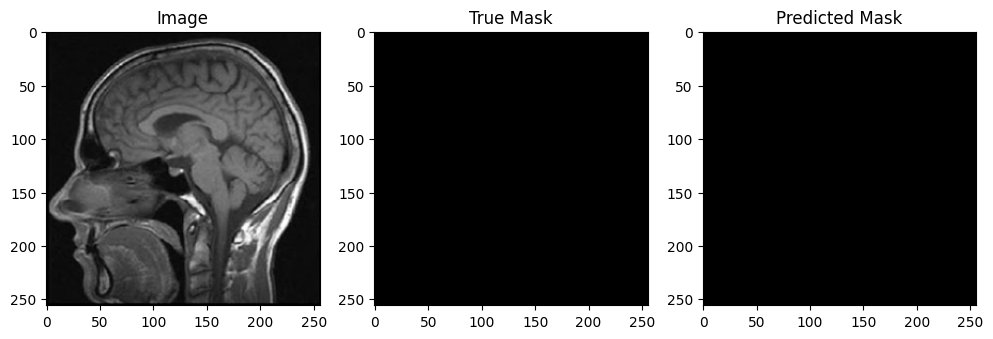

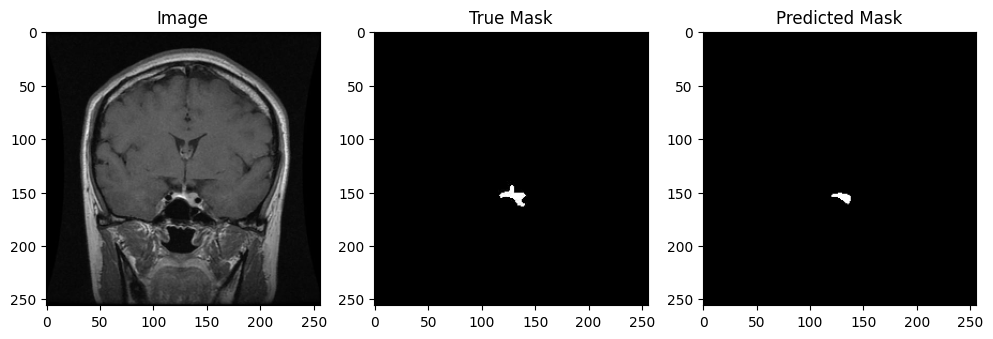

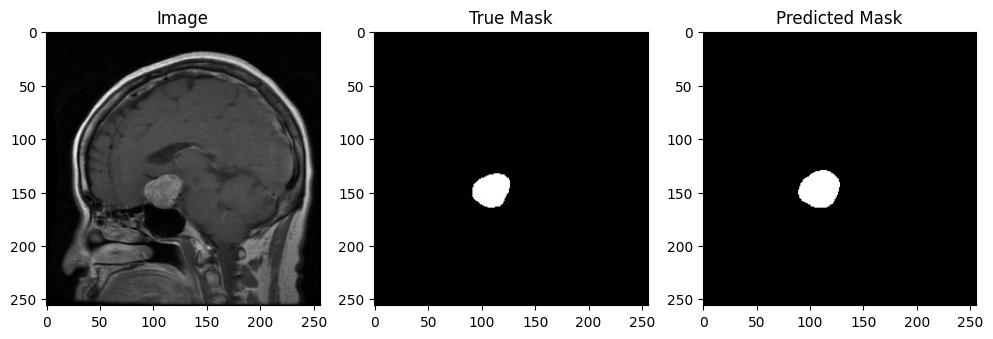

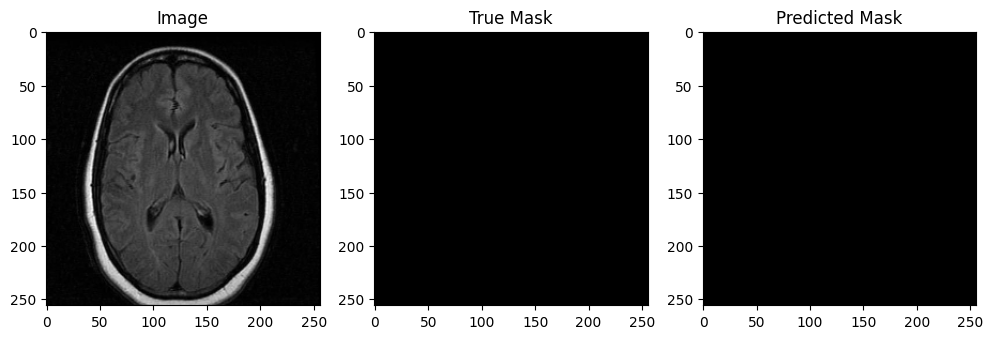

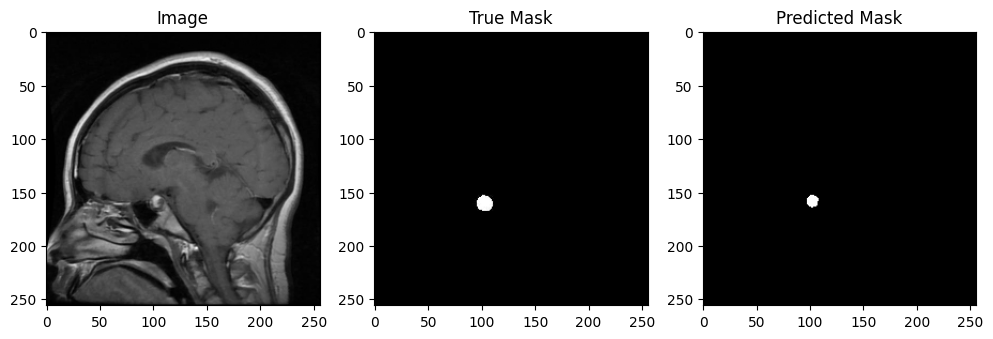

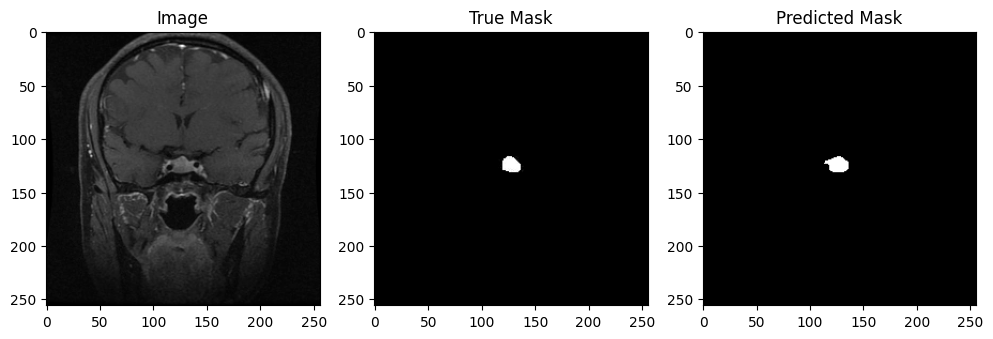

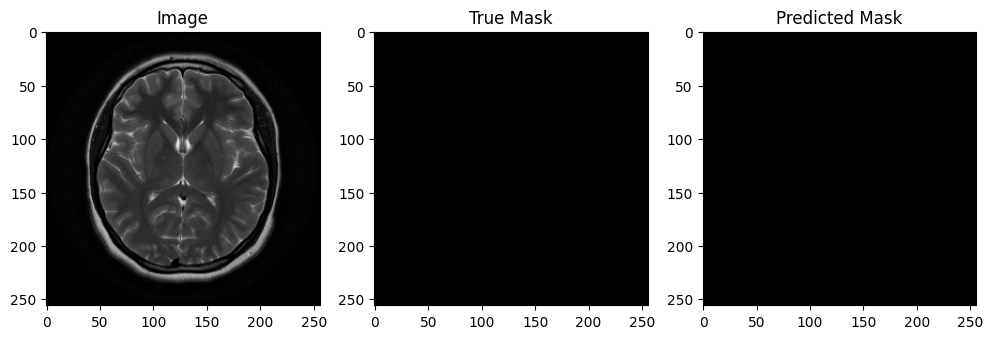

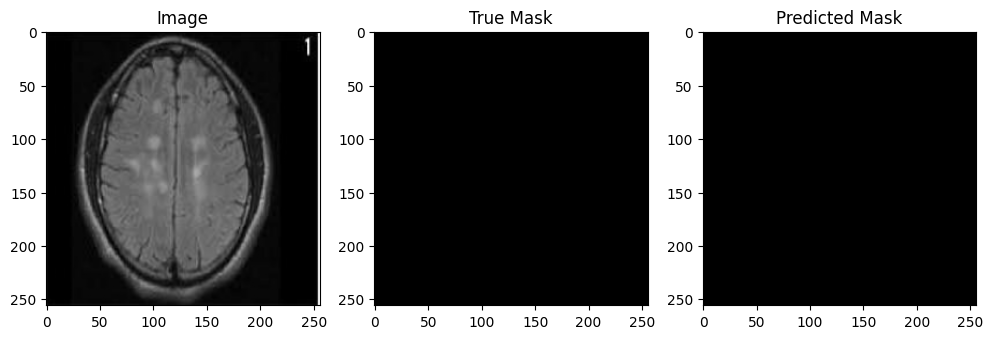

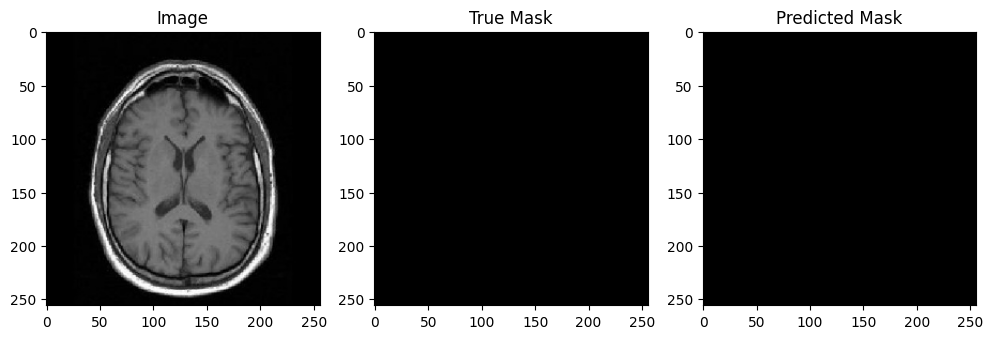

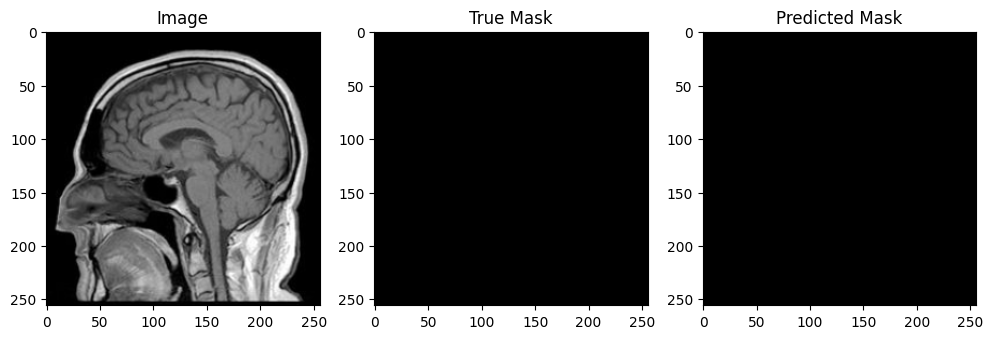

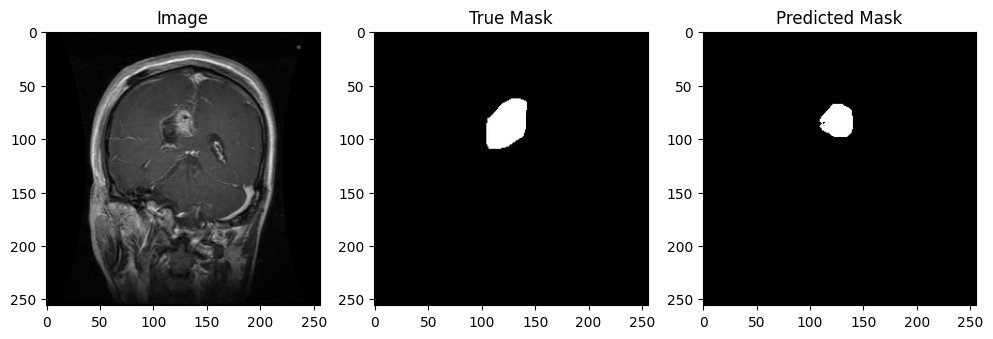

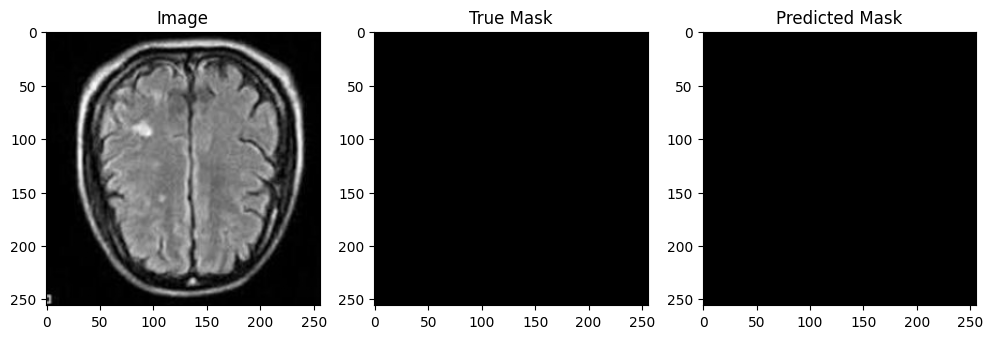

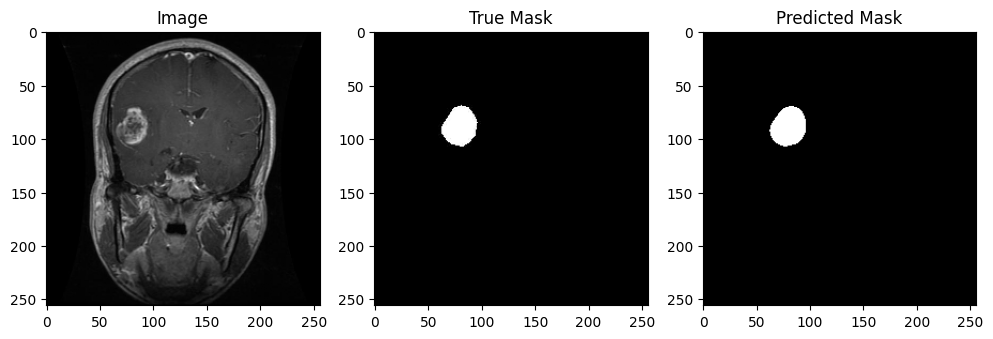

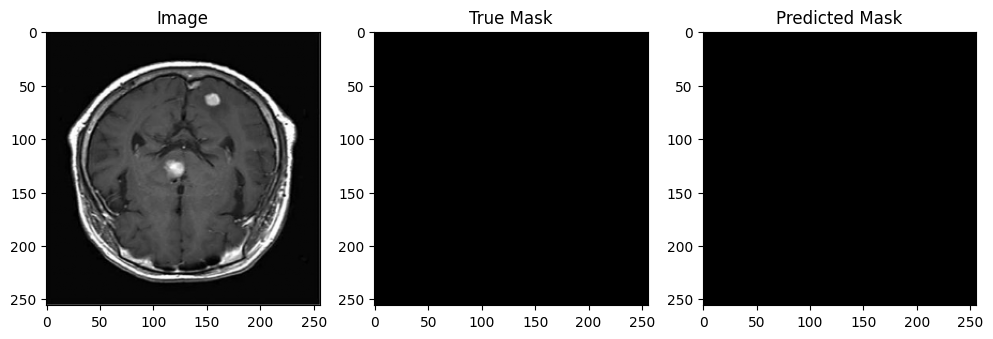

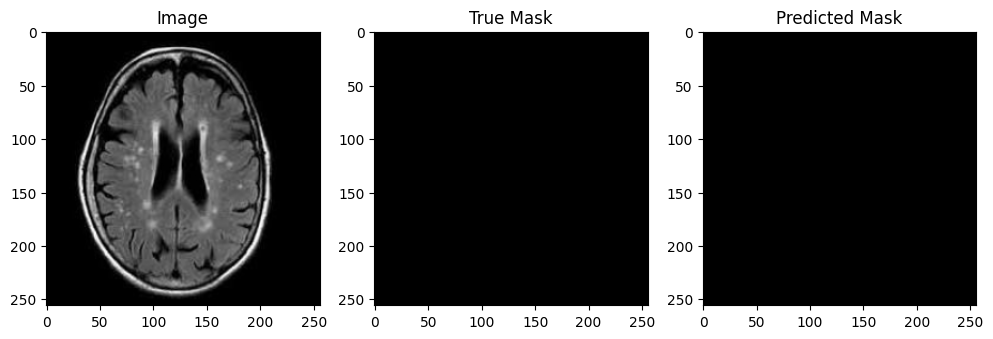

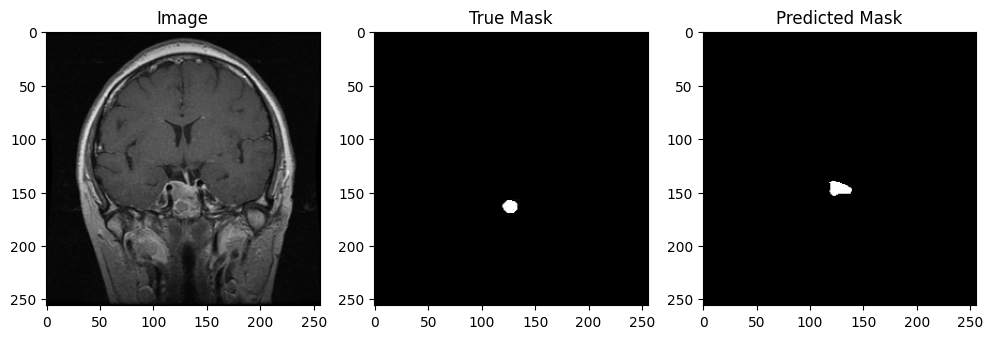

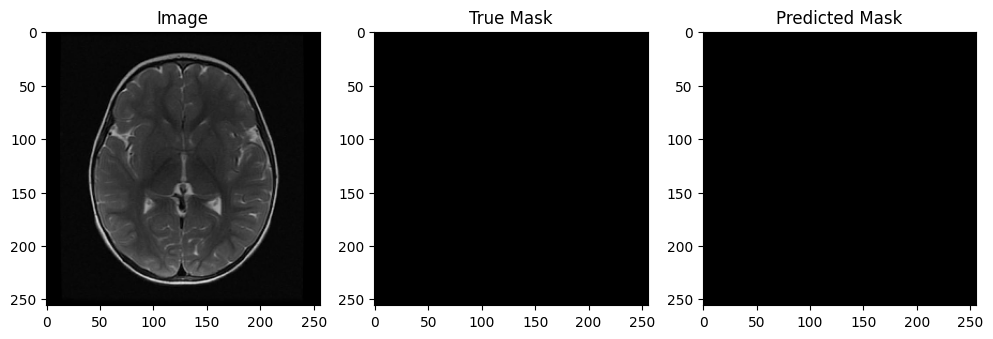

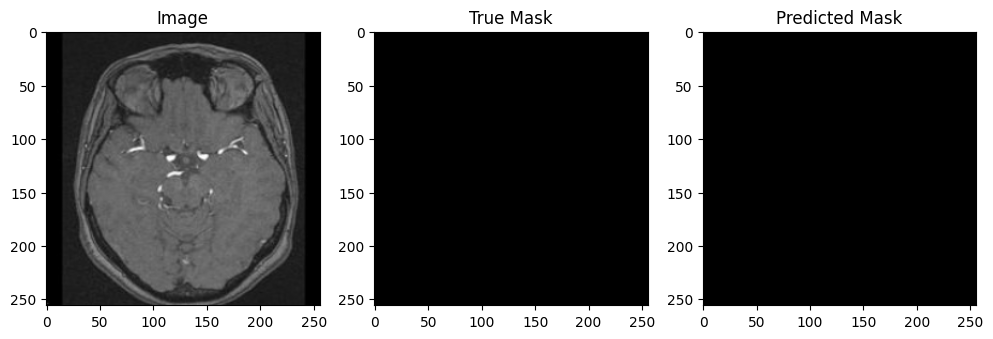

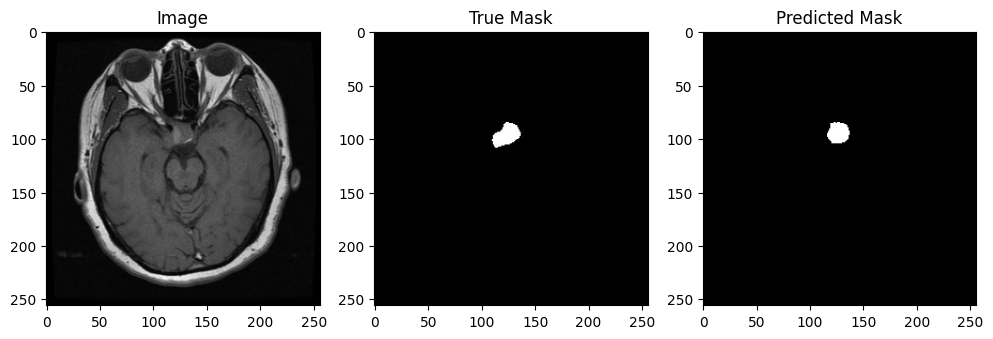

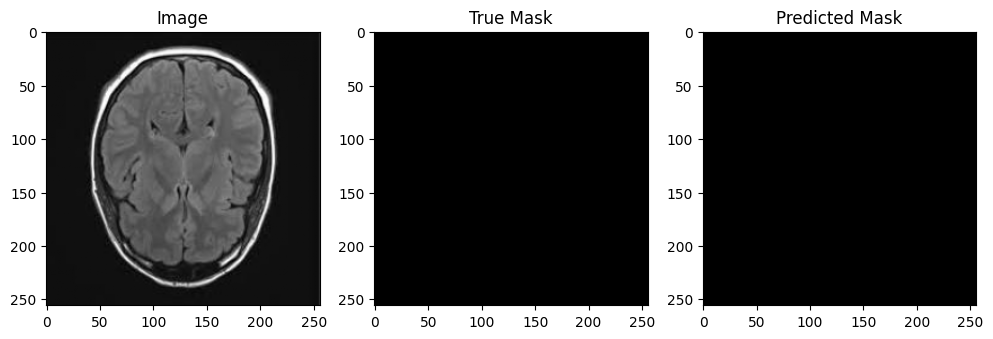

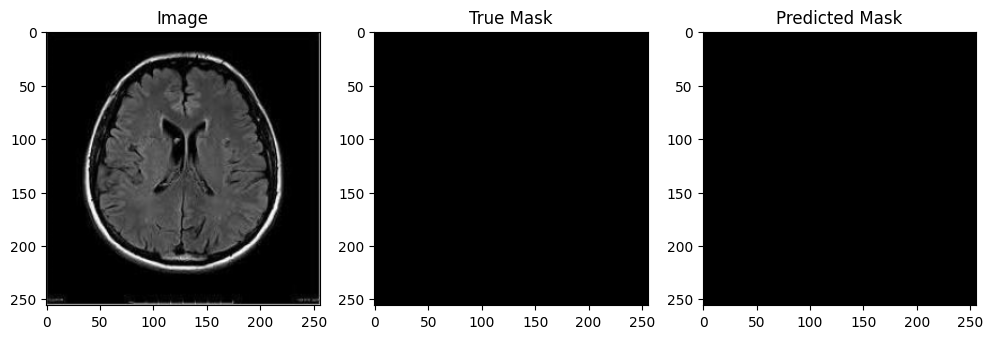

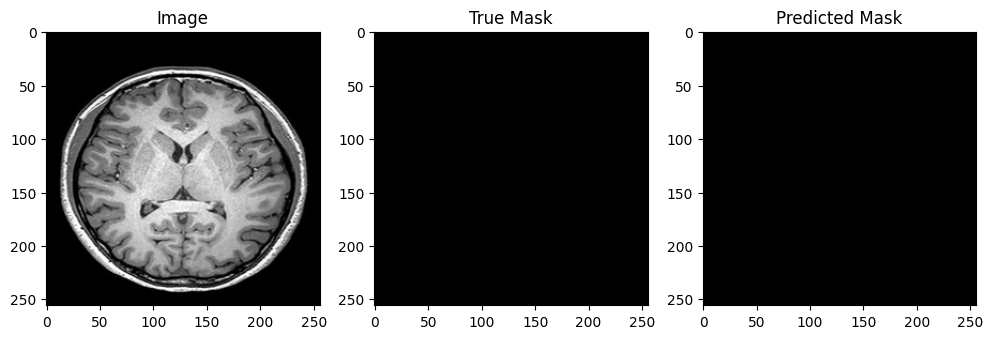

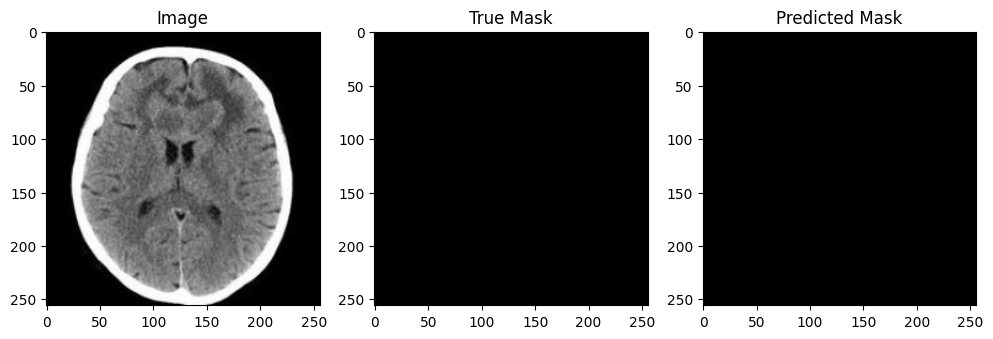

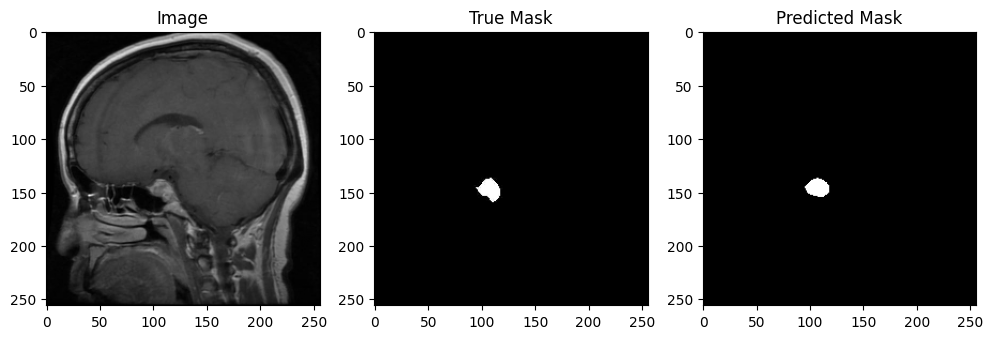

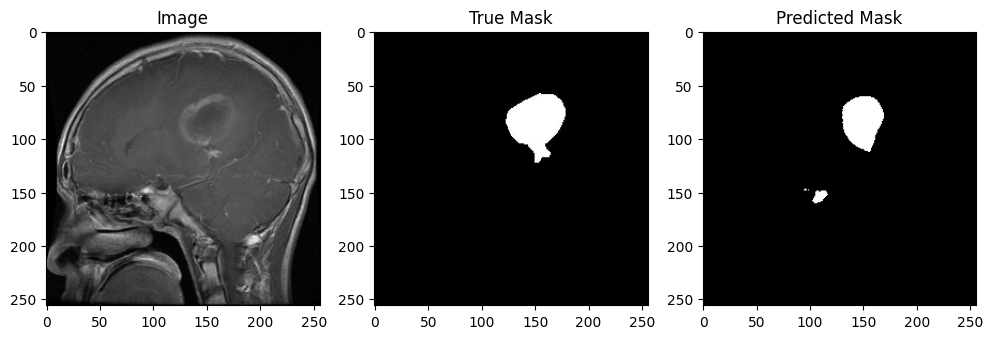

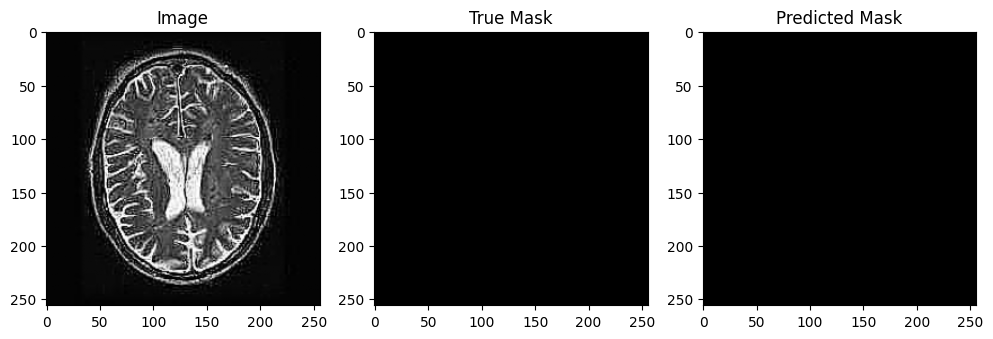

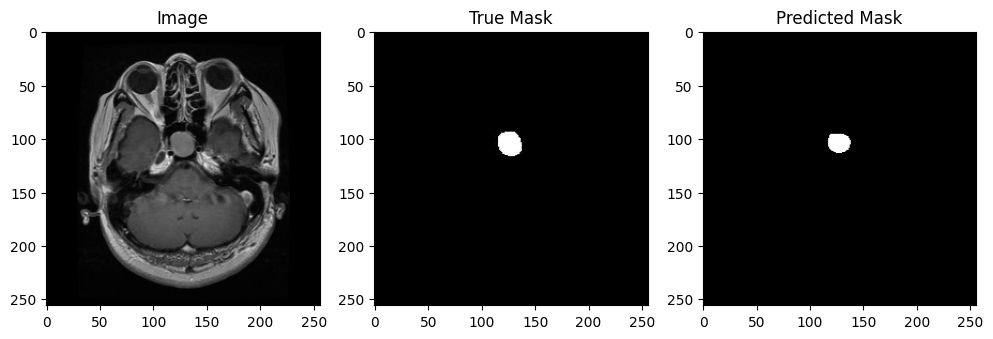

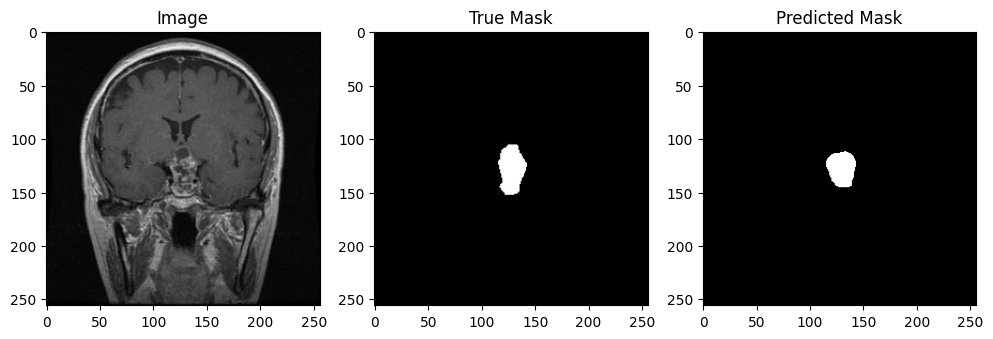

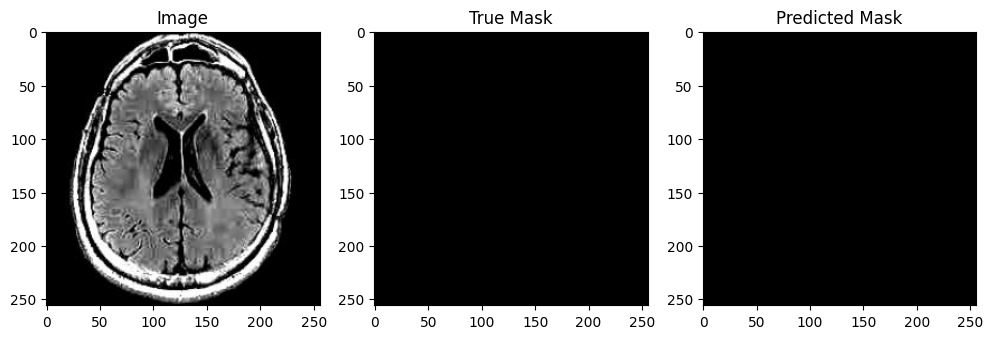

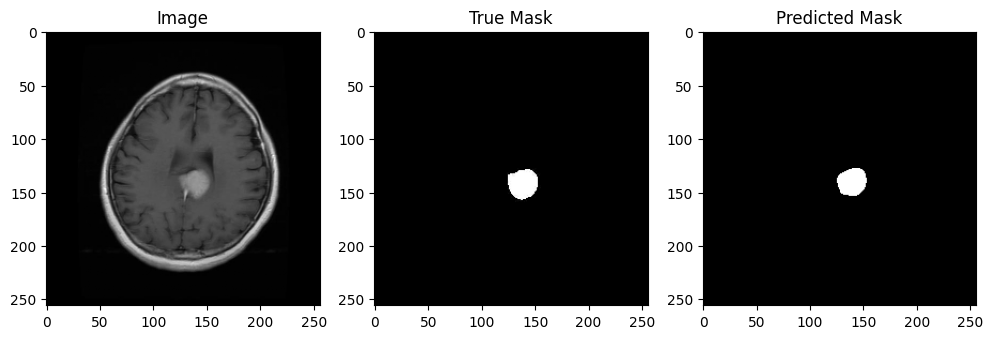

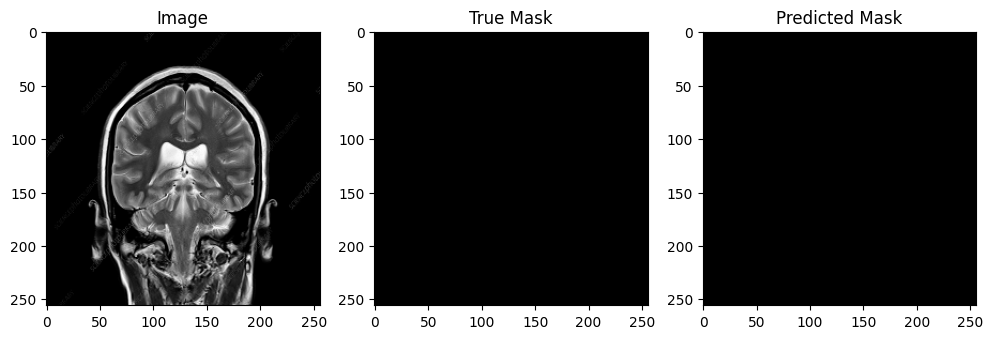

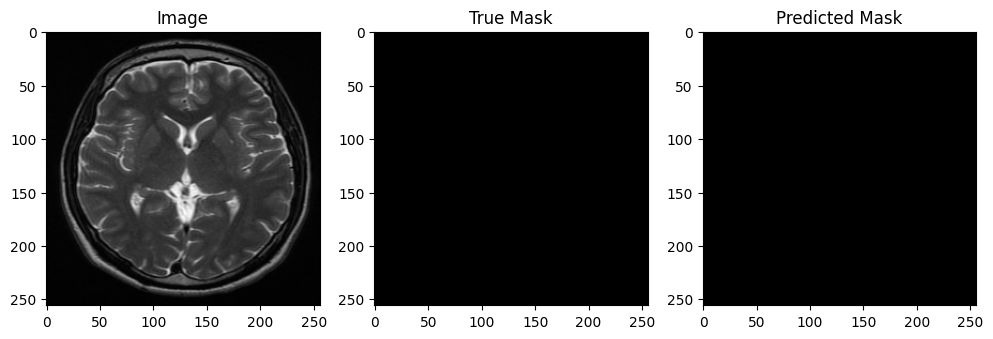

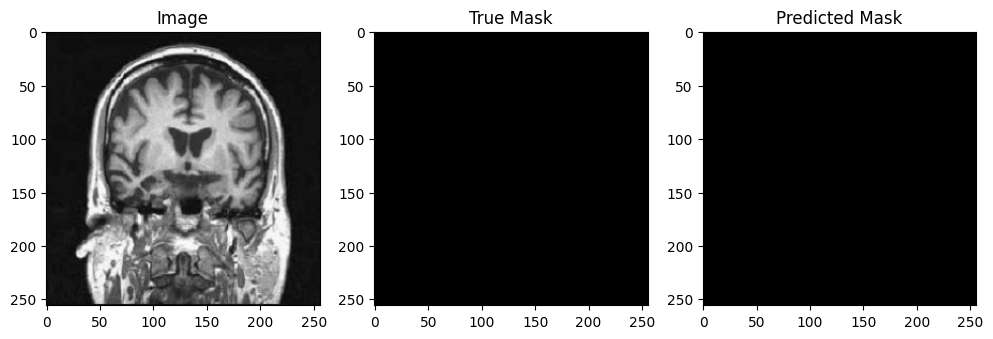

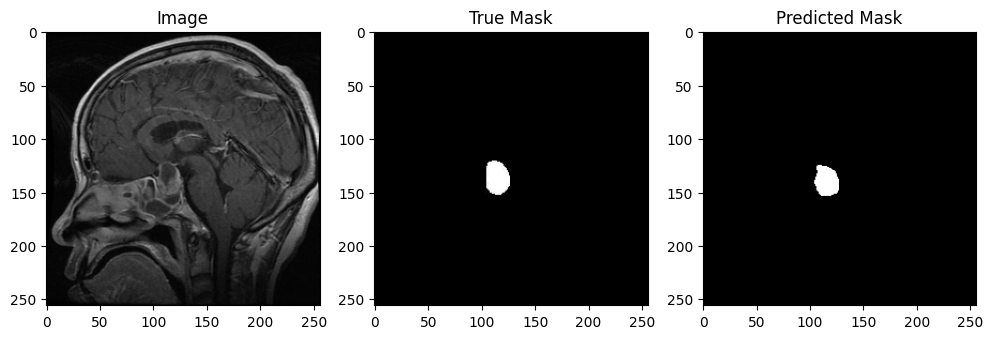

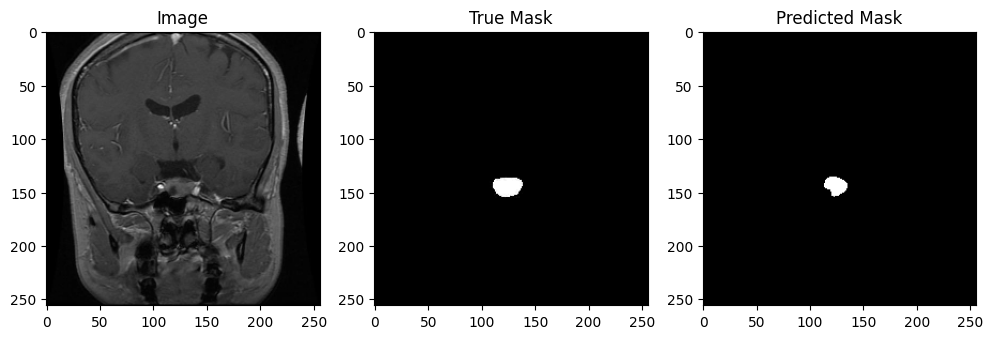

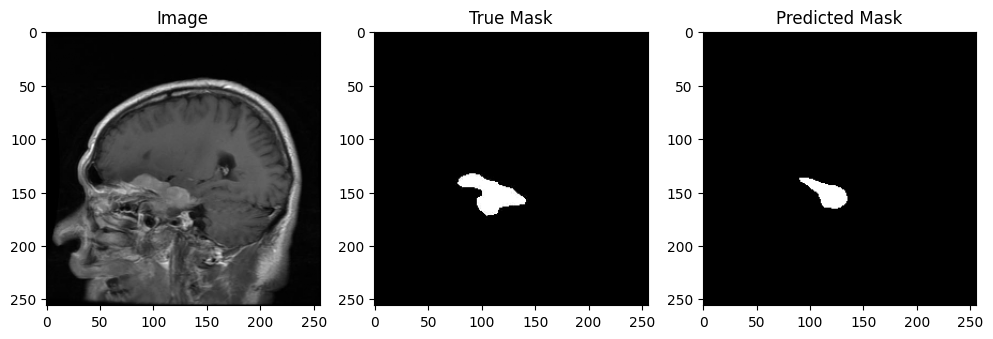

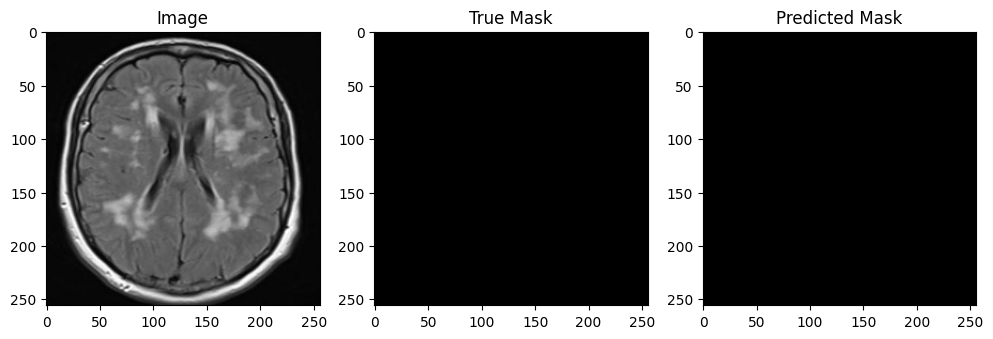

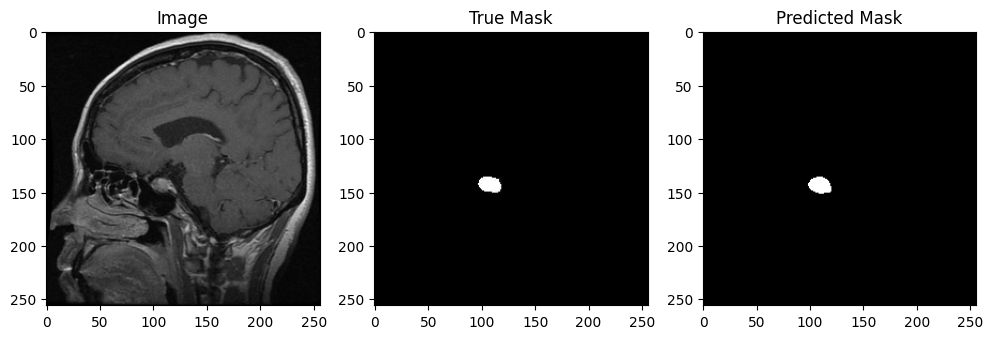

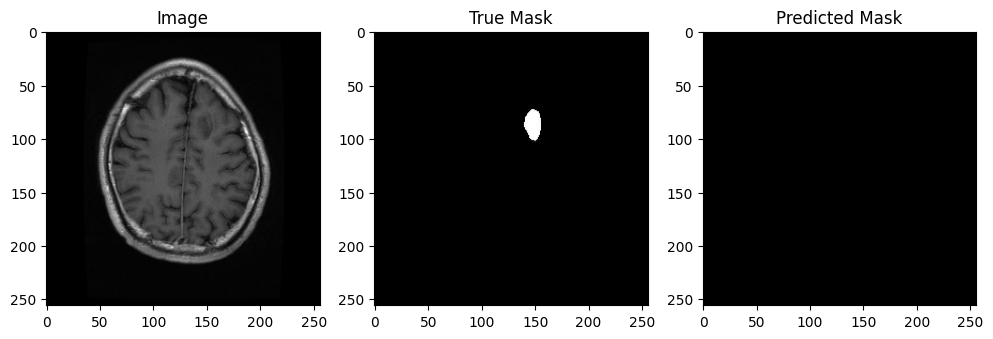

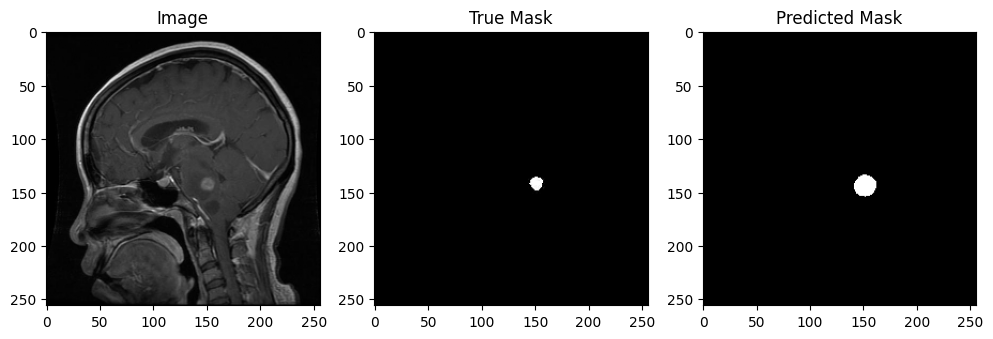

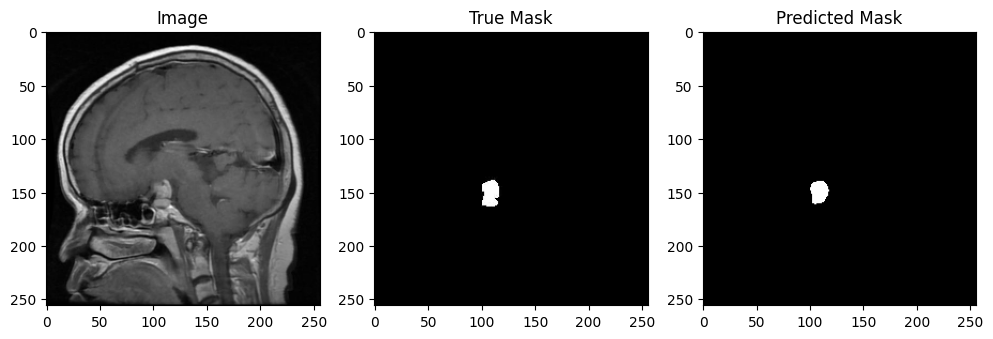

In [59]:
for i in range(50):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()

ResNet

In [60]:
def evaluate_model(model, test_ds, model_name):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, precision, recall, f1, mae, rmse, cm

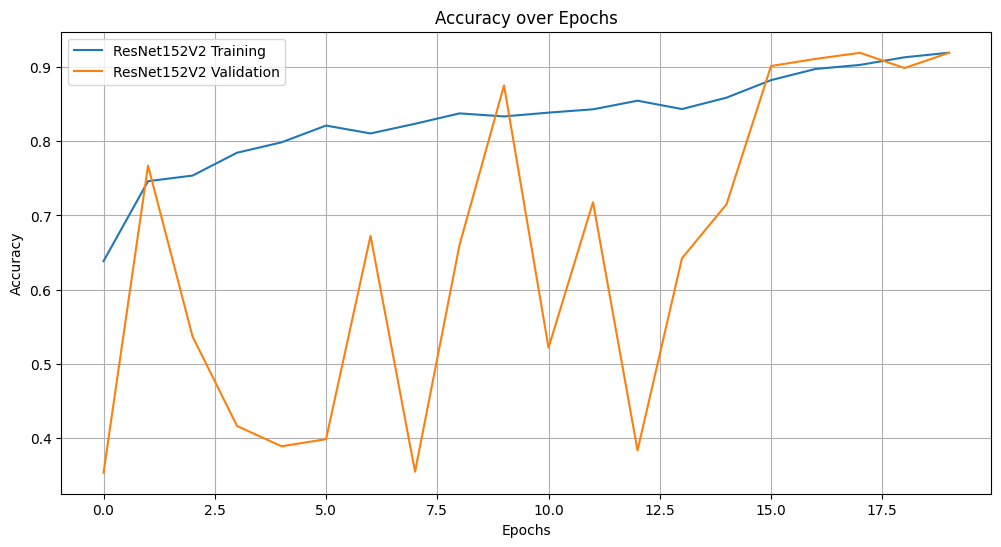

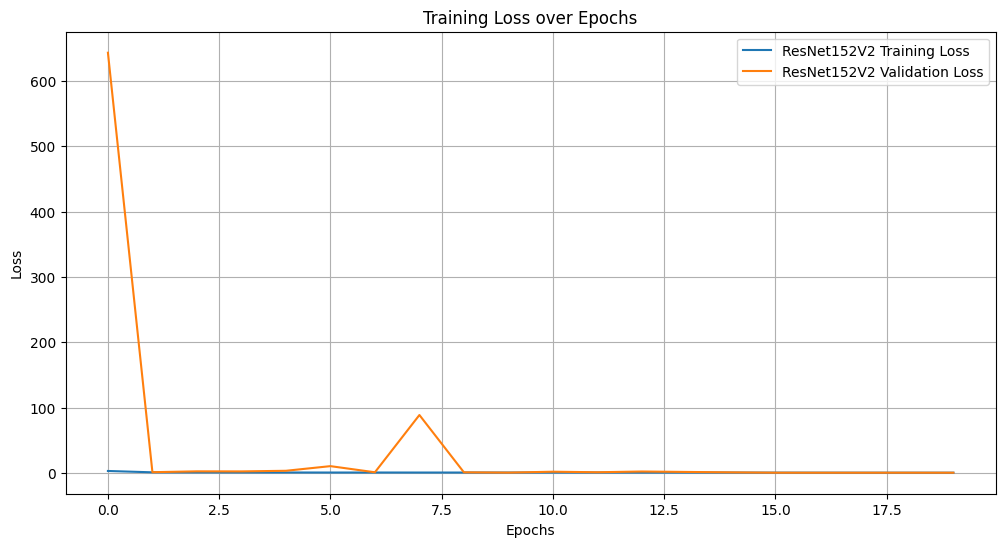

In [61]:
# Define model names
model_names = ["ResNet152V2"]

# Store histories in a list
histories = [history3]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'{model_names[i]} Training')
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]} Validation')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Second Iteration

UNet Modified

In [64]:
def unet_model_with_attention(
    input_size=(256, 256, 1),
    attn_size=(16, 16, 1),
    num_classes=1
):
    # --- Inputs ---
    unet_input = layers.Input(shape=input_size, name="unet_input")
    attention_input = layers.Input(shape=attn_size, name="attention_map_input")

    # --- Encoding (Downsampling) ---
    c1 = layers.Conv2D(64, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(unet_input)
    c1 = layers.Conv2D(64, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # --- Bottleneck ---
    c5 = layers.Conv2D(1024, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu',
                       kernel_initializer='he_normal', padding='same')(c5)

    # ------ Inject attention map by element-wise multiply ------
    # c5: (None, 16, 16, 1024)
    # attention_input: (None, 16, 16, 1)
    # broadcast across 1024 channels
    c5_with_attn = layers.multiply([c5, attention_input])
    # or, simply: c5 * attention_input if you prefer functional

    # --- Decoding (Upsampling) ---
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5_with_attn)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output layer ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    # Build Model with two inputs
    model = keras.models.Model(
        inputs=[unet_input, attention_input],
        outputs=[outputs]
    )
    return model

# Create and compile the new 2-input model
model_mod = unet_model_with_attention(
    input_size=(256, 256, 1),  # e.g. (256,256,1)
    attn_size=(16, 16, 1),            # attention map shape
    num_classes=1
)

model_mod.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', dice_coef]
)

# Print the updated architecture
model_mod.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ unet_input (InputLayer)   │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ unet_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_152[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_44          │ (None, 128, 128, 64)   │              0 │ conv2d_153[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_44[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_155 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_154[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 64, 64, 128)    │              0 │ conv2d_155[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_156 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_45[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_157 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_156[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_46          │ (None, 32, 32, 256)    │              0 │ conv2d_157[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_158 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_46[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_159 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_158[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_47          │ (None, 16, 16, 512)    │              0 │ conv2d_159[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_160 (Conv2D)       │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_47[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_161 (Conv2D)       │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_160[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_map_input       │ (None, 16, 16, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 16, 16, 1024)   │              0 │ conv2d_161[0][0],      │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

ResNet with modification

In [65]:
def create_resnet_with_context(
    input_shape=(256,256,3),
    context_shape=(7,7,1),
    num_classes=4,
    freeze_up_to=10,
    base_learning_rate=1e-4
):
    """
    Returns a Keras model that:
      1) Takes an image of shape `input_shape`
      2) Takes a context map of shape `context_shape`
      3) Multiplies the final conv (7x7x2048) by the (7x7x1) context
      4) Classifies into `num_classes`.
    """

    # 1) Two inputs
    resnet_input = layers.Input(shape=input_shape, name="resnet_input")
    context_input = layers.Input(shape=context_shape, name="context_map_input")  # (7,7,1)

    # 2) Build (or load) ResNet152V2, include_top=False
    #    We'll pass `resnet_input` via `input_tensor=...` or do a separate Model approach
    base_model = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3)
    )

    # Optionally freeze some layers
    for layer in base_model.layers[:freeze_up_to]:
        layer.trainable = False

    # 3) Get final conv output: shape ~ (None, 7, 7, 2048)
    final_conv = base_model.output

    # 4) Multiply final_conv by the context map.
    #    (7,7,1) will broadcast to (7,7,2048).
    final_conv_with_context = layers.Multiply()([final_conv, context_input])

    # 5) Classification Head
    x = layers.GlobalAveragePooling2D()(final_conv_with_context)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # 6) Build model with two inputs
    model = Model(inputs=[resnet_input, context_input], outputs=predictions)

    # 7) Compile
    model.compile(
        optimizer=Adam(learning_rate=base_learning_rate, beta_1=0.9, beta_2=0.999),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

Obtain the context maps...

In [66]:
# Obtain context maps of training set
unscaled_maps_train = model.predict(X_train, verbose=1)
# Use tf.image.resize or cv2.resize
context_maps_train = tf.image.resize(
    unscaled_maps_train,
    (7, 7),
    method='bilinear'
)
# validation set (same as test)
unscaled_maps_val = model.predict(X_test, verbose=1)
context_maps_val = tf.image.resize(
    unscaled_maps_val,
    (7, 7),
    method='bilinear'
)
# Obtain attention map

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


Obtain the attention maps...

In [71]:
def compute_gradcam(
    model,
    images,
    class_indices=None,
    last_conv_layer_name="conv5_block3_out",
    upsample_to=(16,16)
):
    """
    Computes Grad-CAM for a batch of images given a classification model.
      model:              A tf.keras.Model (e.g., ResNet152V2).
      images:             A 4D numpy or tf.Tensor of shape (B, H, W, 3).
      class_indices:      If None, uses the predicted classes. Otherwise,
                          an integer or list of size B specifying which
                          class index to compute Grad-CAM for each image.
      last_conv_layer_name:  Name of the last conv layer in ResNet.
      upsample_to:        Size to which the raw Grad-CAM will be upsampled.

    Returns:
      gradcam_list: A float32 tensor or NumPy array with shape (B, upsample_to[0], upsample_to[1], 1).
    """
    # 1) Create a sub-model that gives us two outputs: (feature_maps, predictions)
    #    where feature_maps is the output of the last_conv_layer,
    #    and predictions is the final classification output.
    last_conv_layer = model.get_layer(last_conv_layer_name)
    sub_model = Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    # 2) Forward pass: get feature maps and predictions
    with tf.GradientTape() as tape:
        feature_maps, predictions = sub_model([images])
        # If class_indices is not given, use the model's predicted class.
        if class_indices is None:
            class_indices = tf.argmax(predictions, axis=1)
        else:
            # Convert to tensor if it's a list or np.array
            class_indices = tf.constant(class_indices, dtype=tf.int32)

        # Gather the scores we want to take gradient wrt
        # shape of predictions: (B, num_classes)
        # shape of targeted_output: (B,)
        targeted_output = tf.gather(predictions, class_indices, axis=1, batch_dims=1)

    # 3) Compute gradients of the targeted class score wrt feature_maps
    grads = tape.gradient(targeted_output, feature_maps)  # shape: (B, Hc, Wc, C)

    # 4) Global-average-pool the gradients (along spatial dims)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))  # shape: (B, C)

    # 5) Weight the feature maps by these pooled grads
    #    We'll do this for each example in the batch
    #    feature_maps has shape (B, Hc, Wc, C)
    #    We multiply each channel c by pooled_grads[b, c] for each example b.
    feature_maps_weighted = feature_maps * tf.reshape(pooled_grads, (-1, 1, 1, feature_maps.shape[3]))

    # 6) Sum across channels to get raw CAM (B, Hc, Wc)
    cam = tf.reduce_sum(feature_maps_weighted, axis=-1)

    # 7) ReLU
    cam = tf.nn.relu(cam)

    # 8) Normalize each CAM to [0,1] for visualization/attention
    #    shape of cam: (B, Hc, Wc)
    eps = 1e-8
    cam_min = tf.reduce_min(cam, axis=[1,2], keepdims=True)
    cam = cam - cam_min
    cam_max = tf.reduce_max(cam, axis=[1,2], keepdims=True) + eps
    cam = cam / cam_max

    # 9) Resize to match the Unet bottleneck or desired size
    cam = tf.expand_dims(cam, axis=-1)  # (B, Hc, Wc, 1)
    cam = tf.image.resize(cam, upsample_to, method="bilinear")  # (B, 16, 16, 1) by default

    return cam


In [68]:
# prompt: mount google drive and read a file into resnet_model

from google.colab import drive
drive.mount('/content/drive')

resnet_model = load_model('/content/model3_resnet152v2_class_weights.keras')

Mounted at /content/drive


On the gradient heatmap export

In [72]:
# Suppose your classification model is:
resnet_model = model3  # or load_model("your_resnet_model.h5")

# Directory where to store Grad-CAM maps
os.makedirs("gradcam_maps", exist_ok=True)

# We iterate over train_ds. Each iteration yields (images, labels).
# images.shape -> (B, 256, 256, 3)
# labels.shape -> (B,)

all_heatmaps = []    # keep them in a list in memory (optional if dataset is small)
all_image_ids = []   # store an identifier for each image

for batch_index, (images, labels) in enumerate(train_ds):
    # images: (B, 256, 256, 3)
    # labels: (B,)

    # 1. Compute Grad-CAM
    #    If you want Grad-CAM wrt the predicted class, pass None for class_indices
    #    If you want Grad-CAM wrt the ground truth label, pass labels.
    batch_cam = compute_gradcam(
        model=resnet_model,
        images=images,
        class_indices=labels,             # use ground-truth or None
        last_conv_layer_name="conv5_block3_out",
        upsample_to=(16,16)
    )  # shape: (B, 16, 16, 1)

    # 2. Store them to disk or in memory
    #    Option A) Write each batch to a .npy file
    #    Option B) Keep them in a big list in memory
    # Option A example:
    np_filename = f"gradcam_maps/batch_{batch_index}.npy"
    np.save(np_filename, batch_cam.numpy())

    # Option B example: (only if fits in memory)
    # all_heatmaps.append(batch_cam.numpy())

    # Possibly store the label or image ID for reference
    # so you can match them up later.
    # If your dataset is built from a directory, you might not
    # have direct filenames here. In that case, you might
    # store the batch index and row inside that batch as an ID.
    # For simplicity:
    # for i in range(batch_cam.shape[0]):
    #     # e.g., image_id = ...
    #     all_image_ids.append( (batch_index, i) )


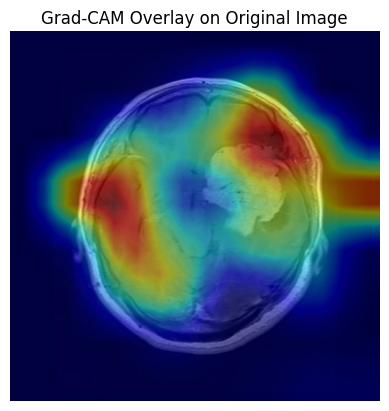

In [77]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the original image.
# For example, assume this image corresponds to the first sample of batch_0.
original_img = cv2.imread("/content/brain-tumor-analysis/split_dataset/UNet/scans/3.jpg")
# Convert from BGR to RGB for plotting
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Load the Grad-CAM heatmap from the saved npy file.
gradcam_batch = np.load("gradcam_maps/batch_0.npy")  # shape: (B, 16, 16, 1)
gradcam_map = np.squeeze(gradcam_batch[2])  # shape becomes (16, 16)

# Resize the Grad-CAM map to match the original image dimensions.
heatmap_resized = cv2.resize(gradcam_map, (original_img.shape[1], original_img.shape[0]))

# Normalize the heatmap between 0 and 1.
heatmap_resized = (heatmap_resized - np.min(heatmap_resized)) / (np.max(heatmap_resized) - np.min(heatmap_resized))

# Display the original image.
plt.imshow(original_img)
# Overlay the heatmap with transparency.
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay on Original Image")
plt.axis("off")
plt.show()


In [ ]:
# Suppose we ended up with arrays:
#    images_unet.shape  -> (N, 256,256,1)
#    masks_unet.shape   -> (N, 256,256,1)
#    gradcams.shape     -> (N, 16,16,1)

# Convert them to TF tensors
images_unet_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
masks_unet_tf  = tf.convert_to_tensor(y_train, dtype=tf.float32)
gradcams_tf    = tf.convert_to_tensor(gradcams, dtype=tf.float32)

dataset_unet = tf.data.Dataset.from_tensor_slices(
    ((images_unet_tf, gradcams_tf), masks_unet_tf)
)
dataset_unet = dataset_unet.batch(batch_size=8, drop_remainder=False)

# Then just feed dataset_unet to your 2-input U-Net:
model_mod.fit(
    dataset_unet,
    epochs=10,
    validation_data=...,  # similarly constructed
)
